Lorenz96 dim = 20 \
LSTM seq = 20 \
Obs gap = 50 \
Con obs = 15 \
Obs function = arctan(x) \
Obs error = 0.01 \
Forward error = 0.1 \
gm_var_ratio = 0.01 + model inher\
eps_a = 1 \
eps_b = 0 \
Fixing x_states \
1000 initial points in training \
100 ensemble size \
Sufficient and inaccurate data, sufficient training on training data \
Inflation to initial std = 0 after observation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import tqdm
import functools
import pandas as pd
from functools import partial
import time
from scipy.integrate import odeint
import torch.utils.data as data
import copy
import math

# Lorenz96 system definition
def lorenz96(x, t, F = 8.0):
    """Lorenz 96 model with constant forcing"""
    return (np.roll(x, -1) - np.roll(x, 2)) * np.roll(x, 1) - x + F 


def initial_state_gen(N, lower_bound = 0, upper_bound = 1):
    if upper_bound <= lower_bound:
        return np.ones(N)
    return np.random.uniform(lower_bound, upper_bound, N)

def lorenz96_solver(initial_state, terminal_time, time_step, F = 8.0):
    t = np.arange(0.0, terminal_time, time_step)
    #sol = solve_ivp(lorenz96, [t[0], t[-1]], initial_state, t_eval = t)
    #return sol
    sol = odeint(lorenz96, initial_state, t)
    return t, sol

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(data.shape[0] - seq_len):
        X.append(data[i:i+seq_len, :])
        y.append(data[i+seq_len, :])
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

def create_data(data, LSTM_seq_len, device):
    data_input, data_output = create_sequences(data, LSTM_seq_len)
    data_input = data_input.to(device)
    #data_input = data_input.transpose(-2,-1).to(device)
    data_output = data_output.to(device)
    return data_input, data_output

class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, hidden_dim=128, num_layers=5):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)

def training_LSTM(model, epochs, optimizer, loss_fn, data_input, data_output, batch_size = 128):
    loader = data.DataLoader(data.TensorDataset(data_input, data_output), shuffle=True, batch_size = batch_size)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in loader:  
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 250 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")


def training_LSTM_main(initial_state, x_dim, time_step, terminal_time, LSTM_seq_len, model, epochs, optimizer, loss_fn, batch_size = 128, F = 8.0, device = 'cpu'):
    t, sol = lorenz96_solver(initial_state, terminal_time, time_step, F)
    data_input, data_output = create_data(sol, LSTM_seq_len, device)
    #current = time.time()
    training_LSTM(model, epochs, optimizer, loss_fn, data_input, data_output, batch_size)
    #print(f"Training time: {time.time() - current}s")

def training_LSTM_inaccurate(initial_state, x_dim, time_step, terminal_time, LSTM_seq_len, model, epochs, optimizer, loss_fn, noise_std = 1, batch_size = 128, F = 8.0, device = 'cpu'):
    t, sol = lorenz96_solver(initial_state, terminal_time, time_step, F)
    data_input, data_output = create_data(sol, LSTM_seq_len, device)
    data_output = data_output + torch.randn_like(data_output) * noise_std
    training_LSTM(model, epochs, optimizer, loss_fn, data_input, data_output, batch_size)

def LSTM_plotting(initial_state, x_dim, time_step, terminal_time, LSTM_seq_len, model, F = 8.0, device = 'cpu'):
    t, sol = lorenz96_solver(initial_state, terminal_time, time_step, F)
    data_input, data_output = create_data(sol, LSTM_seq_len, device)
    model.eval()
    with torch.no_grad():
        predictions = model(data_input).cpu().numpy()

    for i in range(dim_x):
        if_plot = np.random.randint(2)
        if if_plot:
            plt.plot(t[LSTM_seq_len: ], sol[LSTM_seq_len: , i], label = 'dim ' + str(i + 1), color = 'blue')
            plt.plot(t[LSTM_seq_len: ], predictions[:, i],  label = 'prediction', color = 'red')
            plt.legend(loc = 'upper right')
            plt.show()

def testing_dataset_MSE(initial_state, x_dim, time_step, terminal_time, LSTM_seq_len, model, F = 8.0, device = 'cpu'):
    t, sol = lorenz96_solver(initial_state, terminal_time, time_step, F)
    data_input, data_output = create_data(sol, LSTM_seq_len, device)
    model.eval()
    with torch.no_grad():
        predictions = model(data_input).cpu()

    return loss_fn(predictions, torch.Tensor(sol[LSTM_seq_len:, :]))

In [4]:
dim_x = 20
F = 8.0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMModel(input_dim = dim_x, output_dim = dim_x).to(device)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
initial_state = np.ones(dim_x) * 8.0
initial_state[0] += 0.5
total_data_size = 2500
terminal_time = 10
time_step = terminal_time / total_data_size
LSTM_seq_len = 20
EPOCHS = 200
batch_size = 128
device

'cuda'

In [4]:
#initial_state = initial_state_gen(dim_x, 7, 9)
train_test_loss = []
train_test_initial = initial_state_gen(dim_x, 7, 9)
train_test_loss_fix = []

In [6]:
current_time = time.time()
noise_std = 0.2
for i in range(500):
    if (i + 1) % 20 == 0:
        print("Iteration", i + 1)
    if (i + 1) % 100 == 0:
        print("Time:", (time.time() - current_time) / 60)
        current_time = time.time()
    initial_state = initial_state_gen(dim_x, 7, 9)
    training_LSTM_inaccurate(initial_state, dim_x, time_step, terminal_time, LSTM_seq_len, model, EPOCHS, optimizer, loss_fn, noise_std, batch_size, F, device)
    train_test_loss.append(testing_dataset_MSE(initial_state_gen(dim_x, 7, 9), dim_x, time_step, terminal_time, LSTM_seq_len, model, F, device).detach().numpy())
    train_test_loss_fix.append(testing_dataset_MSE(train_test_initial, dim_x, time_step, terminal_time, LSTM_seq_len, model, F, device).detach().numpy())
    if (i + 1) % 100 == 0:
        torch.save(model.state_dict(), 'LSTM_Lorenz96_35_' + str((i + 1) // 100) + '00.pth')
#LSTM_plotting(initial_state, dim_x, time_step, terminal_time, LSTM_seq_len, model, F, device)

Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Time: 42.85736121336619
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Time: 43.72121006647746
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Time: 43.31029330889384
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Time: 43.131603093942005
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Iteration 500
Time: 43.310537950197855


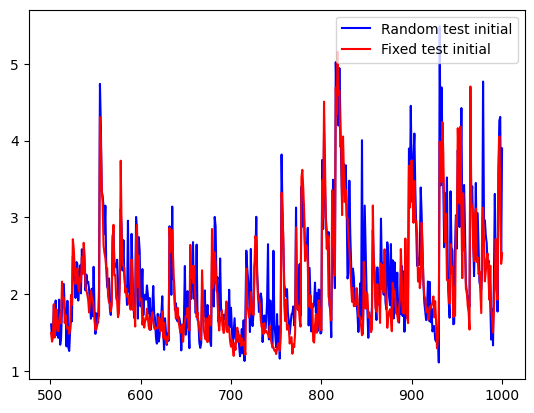

In [7]:
plt.plot(np.arange(500) + 501, train_test_loss, color = 'blue', label = 'Random test initial')
plt.plot(np.arange(500) + 501, train_test_loss_fix, color = 'red', label = 'Fixed test initial')
plt.legend(loc = 'upper right')
plt.show()

In [5]:
model.load_state_dict(torch.load('LSTM_Lorenz96_35_500.pth'))

<All keys matched successfully>

In [ ]:
#torch.save(model.state_dict(), 'LSTM_Lorenz96_29.pth')

In [8]:
df = pd.DataFrame({'LSTM_training_loss_random_initial': train_test_loss, 
                   'LSTM_training_loss_fixed_initial': train_test_loss_fix})

df.to_csv('LSTM_training_loss_1000_inaccurate.csv', index = False)
df.head()

LSTM_training_loss_random_initial LSTM_training_loss_fixed_initial
0                         1.6082263                        1.4966619
1                         1.4246371                        1.3843043
2                         1.4830128                        1.4347997
3                         1.8600864                        1.8715599
4                         1.5835756                        1.4371759

In [9]:
test_df = pd.read_csv('LSTM_training_loss_1000_inaccurate.csv')
test_df.head()

LSTM_training_loss_random_initial  LSTM_training_loss_fixed_initial
0                           1.608226                          1.496662
1                           1.424637                          1.384304
2                           1.483013                          1.434800
3                           1.860086                          1.871560
4                           1.583576                          1.437176

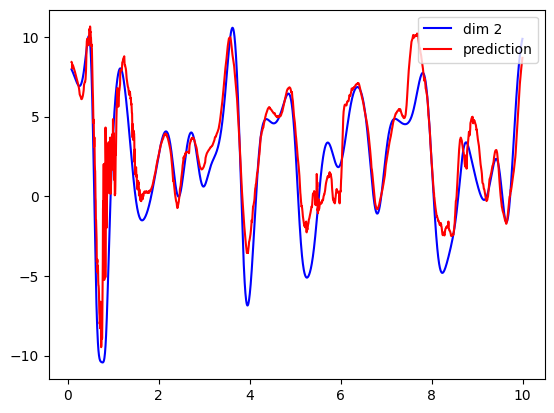

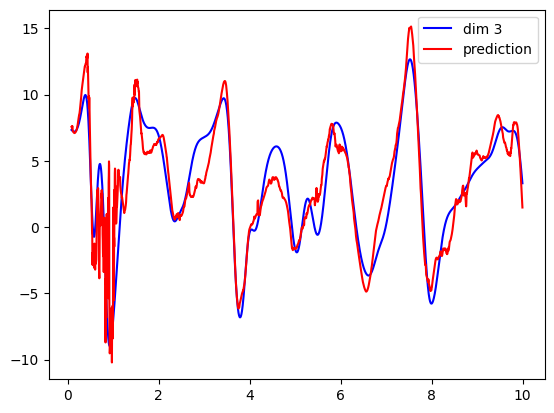

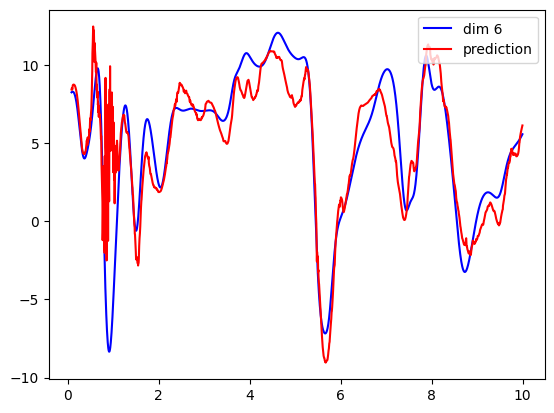

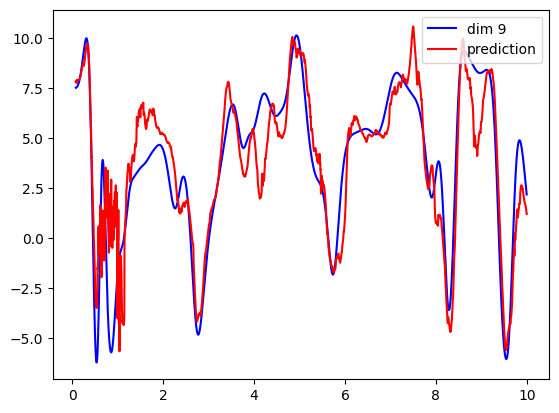

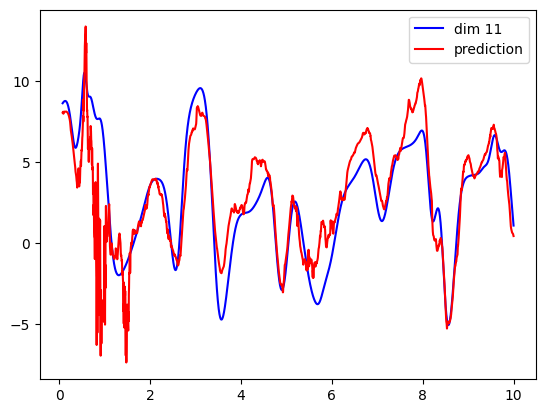

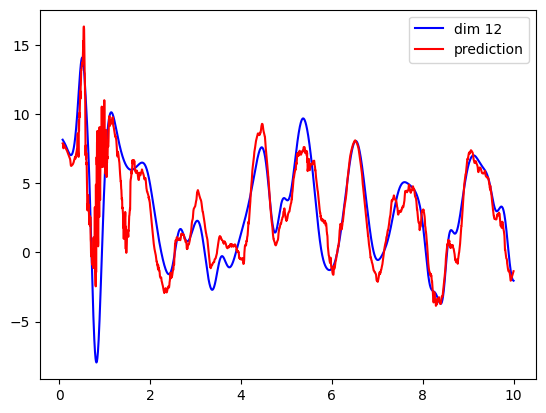

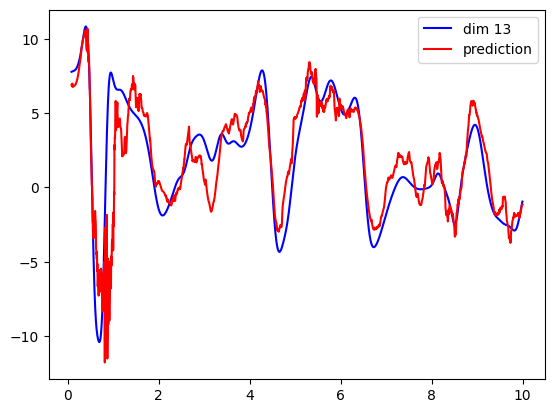

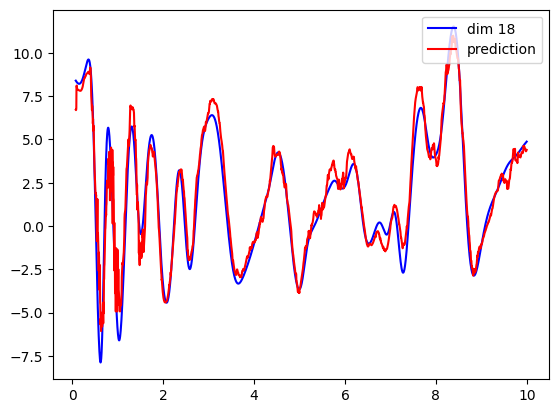

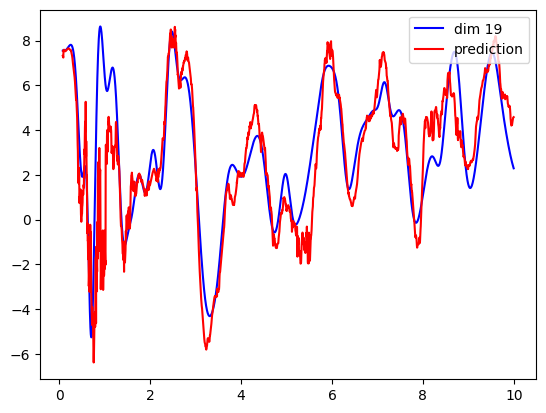

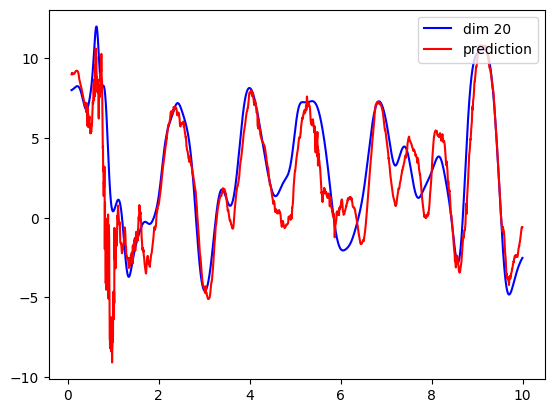

In [4]:
LSTM_plotting(initial_state_gen(dim_x, 7, 9), dim_x, time_step, terminal_time, LSTM_seq_len, model, F, device)

In [6]:
model_inher = testing_dataset_MSE(initial_state_gen(dim_x, 7, 9), dim_x, time_step, terminal_time, LSTM_seq_len, model, F, device)
for _ in range(99):
    model_inher = model_inher + testing_dataset_MSE(initial_state_gen(dim_x, 7, 9), dim_x, time_step, terminal_time, LSTM_seq_len, model, F, device)

In [7]:
model_inher = float(model_inher.detach().numpy()) / 100
model_inher, device

(3.020768737792969, 'cuda')

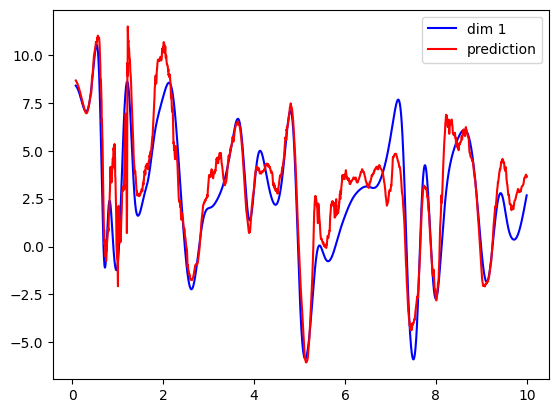

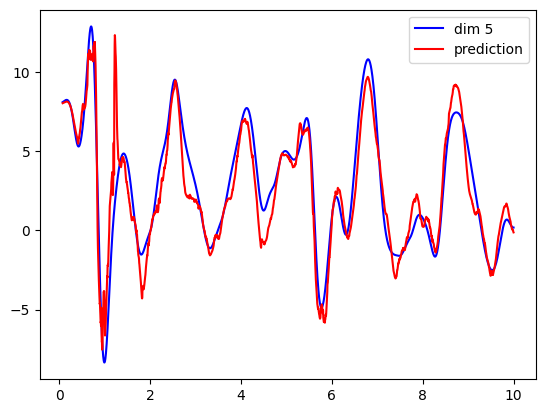

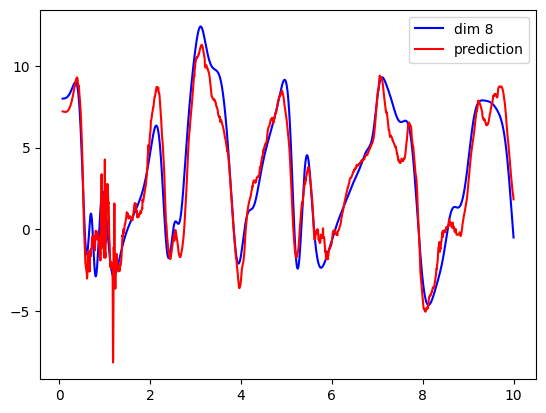

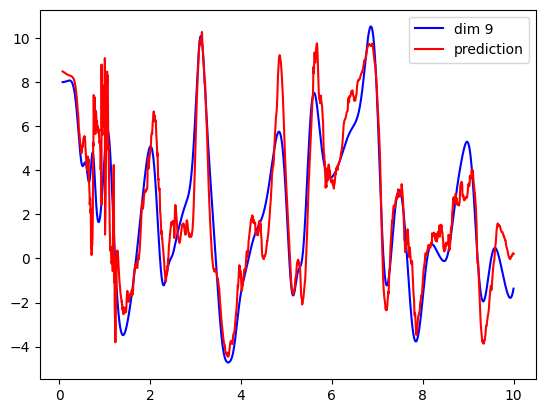

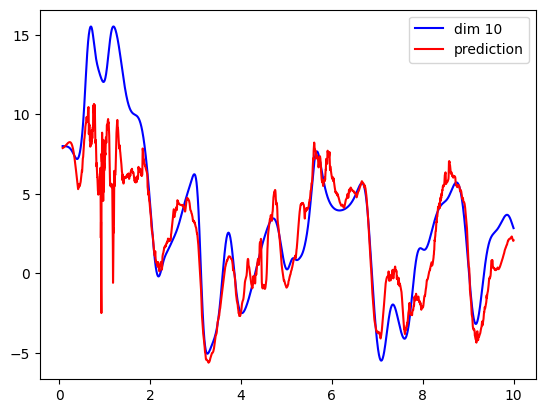

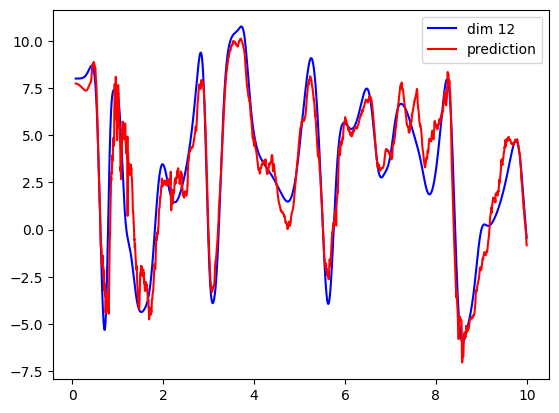

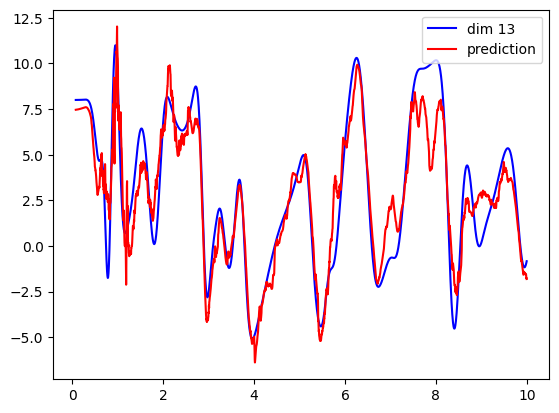

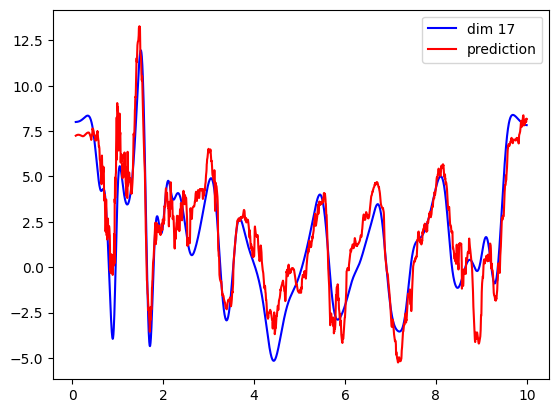

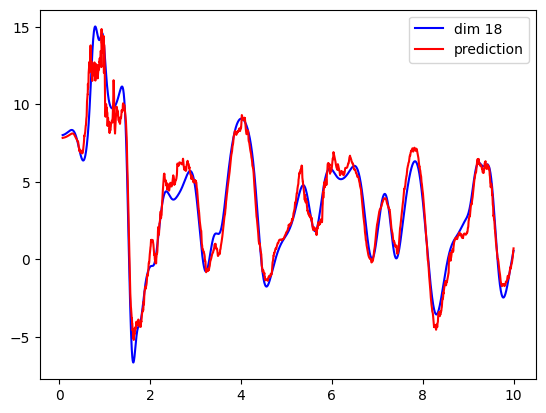

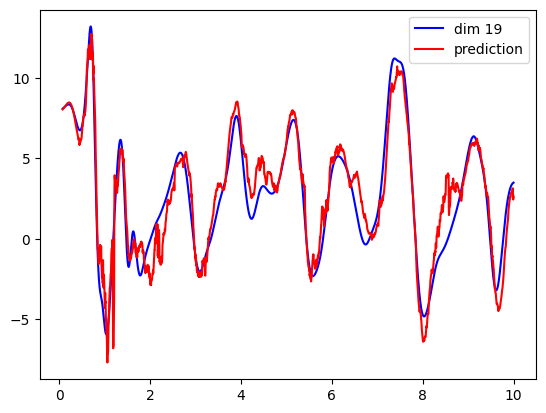

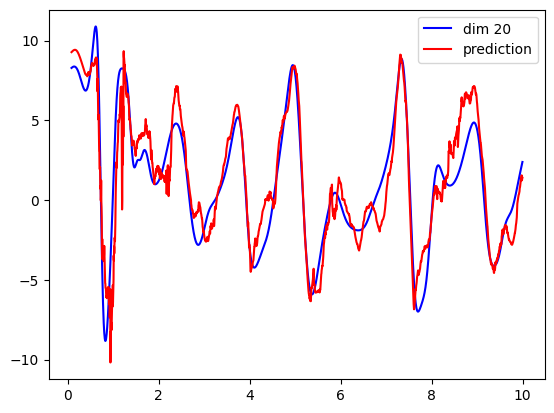

In [8]:
initial_state = np.ones(dim_x) * 8.0
initial_state[0] += 0.5
LSTM_plotting(initial_state, dim_x, time_step, terminal_time, LSTM_seq_len, model, F, device)

# EnSF

In [9]:
from diffusion import *

In [10]:
#model.load_state_dict(torch.load('./LSTM_Lorenz96_1.pth',weights_only=True, map_location=torch.device('cpu')))
model.eval()

LSTMModel(
  (lstm): LSTM(20, 128, num_layers=5, batch_first=True)
  (fc): Linear(in_features=128, out_features=20, bias=True)
)

In [11]:
def crps_batch(ensemble, state_true):
    x_sort = torch.sort(ensemble,dim=0)[0]
    result = torch.zeros_like(state_true)

    for i in range(ensemble_size+1):
        if i == 0:
            bin_left = -100
            bin_right = x_sort[i,:]
        elif i==ensemble_size:
            bin_left = x_sort[i-1,:]
            bin_right = 100
        else:
            bin_left = x_sort[i-1,:]
            bin_right = x_sort[i,:]

        temp1 = (bin_right - bin_left) * (float(i)/ensemble_size)**2
        temp2 = (bin_right - bin_left)* (1.0 - float(i)/ensemble_size)**2 * (state_true <= bin_left)
        temp3 = (state_true - bin_left)* (float(i)/ensemble_size)**2 + (bin_right - state_true)* (1.0 - float(i)/ensemble_size)**2
        result += temp1 * (state_true >= bin_right) + temp2 * (state_true <= bin_left) + temp3 * (state_true < bin_right) * (state_true > bin_left)
    return result



def rank_count(ensemble, target):
    ensemble_size = ensemble.shape[0]
    state_rank = torch.sum(ensemble > target[None ,:], dim=0)
    count = np.array([torch.sum(state_rank==i).item() for i in range(ensemble_size+1)])
    return count

#obs_fun = lambda x: x
obs_fun = lambda x: torch.atan(x)
def atan_score_ana(xt, obs_value):
    score_x = -(torch.atan(xt) - obs_value)/obs_sigma**2 * (1./(1. + xt**2))
    #score_x = -(xt - obs_value) / obs_sigma ** 2
    return score_x


In [12]:
# computing setup
#device = 'cuda'

default_dtype = torch.float32

save_dir = 'results'
print_step_info = True
save_result = False
save_plot = True

# L96 clip value
clip_tol = 50


# computing setting
print(f'computing setting:')
print(f'\tdevice: \t\t\t{device}')
print(f'\tprint_step_info: \t{print_step_info}')
print(f'\tsave_result: \t\t{save_result}')
print(f'\tsave_plot: \t\t\t{save_plot}')
print(f'\tclip_tol: \t\t\t{clip_tol}')

###############################################################
# load all parameters
###############################################################
param_combined = pd.read_csv('param_combined.csv')
total_run = param_combined.shape[0]
print(f'total run: {total_run}')

computing setting:
	device: 			cuda
	print_step_info: 	True
	save_result: 		False
	save_plot: 			True
	clip_tol: 			50
total run: 1


In [13]:
local_run_list = np.arange(total_run)
print(f'local run: {local_run_list}')

local run: [0]


In [14]:
#initial_state = initial_state_gen(-10, 10)
#initial_state = [F for i in range(dim_x)]
#initial_state[0] += 0.01
#t, sol = lorenz96_solver(initial_state, terminal_time, time_step, F)
#test_data_ensf = torch.tensor(sol[LSTM_seq_len: , :], dtype=torch.float32).to(device)
#np.savetxt("lorenz96_20.txt", sol)

In [15]:
initial_state = [F for i in range(dim_x)]
initial_state[0] += 0.01
t = np.linspace(0, terminal_time, total_data_size, endpoint = False)
sol = np.loadtxt("lorenz96_20.txt", dtype = 'float64')
test_data_ensf = torch.tensor(sol[LSTM_seq_len: , :], dtype = torch.float32).to(device)

run_index: 90
	save name: run_90_prob_3_method_0_init_0_seed_0
	problem id: 3
		dim_x: 			20
		obs_gap: 		1
		obs_sigma: 		0.01
		dt: 			0.01
	method id: 0
		ensemble_size: 	100
		Nt_SDE: 	500
		solver: 	SDE_euler
		gm_var_ratio: 	3.0307687377929686
		inflation: 	1
		eps_a: 	1
		eps_b: 	0
Step 100
Step 200
Step 300
Step 400
Step 500
step 500 DA:
	 before DA: 1.9837
	  after DA: 0.5239
	      time: 0.3926
Step 600
Step 700
Step 800
Step 900
Step 1000
step 1000 DA:
	 before DA: 1.1188
	  after DA: 0.5534
	      time: 0.3935
Step 1100
Step 1200
Step 1300
Step 1400
Step 1500
step 1500 DA:
	 before DA: 1.4488
	  after DA: 0.2149
	      time: 0.5730
Step 1600
Step 1700
Step 1800
Step 1900
Step 2000
step 2000 DA:
	 before DA: 1.4852
	  after DA: 0.4928
	      time: 0.5761
Step 2100
Step 2200
Step 2300
Step 2400
run_90_prob_3_method_0_init_0_seed_0:
	final rmse:	0.2846


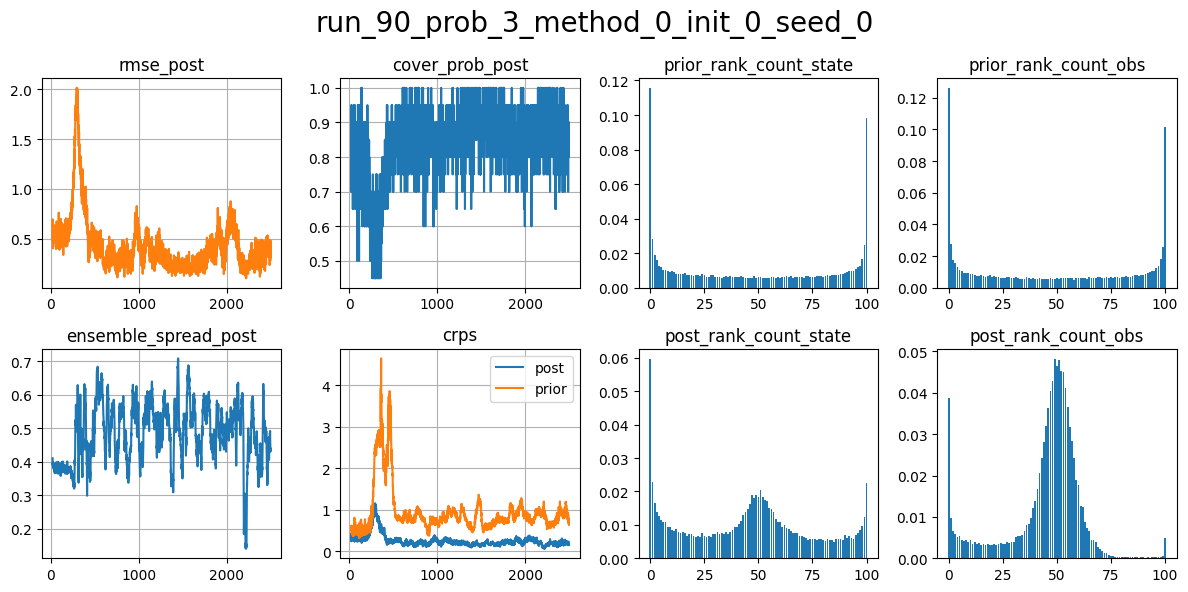

In [17]:
# temp local run data
for local_run_id in local_run_list:
    local_param = param_combined.loc[[local_run_id]] #take parameters from list of tests to run


    # case_index
    run_index = local_param['run_index'].iloc[0]

    # problem parameter
    problem_id = local_param['problem_id'].iloc[0]
    seed = local_param['seed'].iloc[0]
    init_id = local_param['init_id'].iloc[0]
    #dim_x = local_param['dim_x'].iloc[0]
    #dim_x=100000
    #dim_x=20 #20-dimensional Lorenz-96
    #shock_dir = local_param['shock_dir'].iloc[0]
    obs_gap= 1
    consecutive_obs = 15
    initial_state_std = 1
    #obs_gap = local_param['obs_gap'].iloc[0]
    #obs_sigma = local_param['obs_sigma'].iloc[0]
    obs_sigma = 0.01
    obs_range = math.atan(15)
    dt = local_param['dt'].iloc[0]
    N_step = len(test_data_ensf)

    #N_step = local_param['N_step'].iloc[0]
    #state_init_all = np.load(f'./state_init_d_{dim_x}_rep_10.npy')
    #if shock_dir == shock_dir:
        #shock_profile = np.load('./shock_profile_1.npy')
    #else:
        #shock_profile = np.zeros(N_step)


    # getup filter param
    solver_all = ['SDE_euler', 'ODE_euler', 'DPM_solver']
    def damp_fn(t):
        return (1-t) * 1.0

    method_id = local_param['method_id'].iloc[0]
    #ensemble_size = local_param['ensemble_size'].iloc[0]
    ensemble_size=100

    Nt_SDE = local_param['Nt_SDE'].iloc[0]
    #gm_var_ratio = local_param['gm_var_ratio'].iloc[0]
    forward_error = 0.1
    gm_var_ratio = forward_error ** 2 + model_inher
    inflation = local_param['inflation'].iloc[0]
    solver_type = local_param['solver_type'].iloc[0] #'SDE_euler'=0, 'ODE_euler'=1, 'DPM_solver=2'
    #eps_a = local_param['eps_a'].iloc[0]
    eps_a = 1
    #eps_b = local_param['eps_b'].iloc[0]
    eps_b = 0
    solver = solver_all[solver_type]
    # EnSF
    ns = NoiseSchedule(ns_type='linear', eps_a=eps_a, eps_b=eps_b)
    dm = ReverseSampler(noise_schedule=ns)
    score_rep = ScoreRep(dm=dm, dim_x=dim_x, obs_model=obs_fun, obs_sigma=obs_sigma)


    # save name
    save_name = f'run_{run_index}_prob_{problem_id}_method_{method_id}_init_{init_id}_seed_{seed}'

    # print info
    print(f'run_index: {run_index}')

    # problem data
    print(f'\tsave name: {save_name}')
    print(f'\tproblem id: {problem_id}')
    #print(f'\t\tshock_dir: \t\t{shock_dir}')
    print(f'\t\tdim_x: \t\t\t{dim_x}')
    print(f'\t\tobs_gap: \t\t{obs_gap}')
    print(f'\t\tobs_sigma: \t\t{obs_sigma}')
    print(f'\t\tdt: \t\t\t{dt}')

    # method data
    print(f'\tmethod id: {method_id}')
    print(f'\t\tensemble_size: \t{ensemble_size}')
    print(f'\t\tNt_SDE: \t{Nt_SDE}')
    print(f'\t\tsolver: \t{solver}')
    print(f'\t\tgm_var_ratio: \t{gm_var_ratio}')
    print(f'\t\tinflation: \t{inflation}')
    print(f'\t\teps_a: \t{eps_a}')
    print(f'\t\teps_b: \t{eps_b}')


    #forward_fn = functools.partial(rk4, fn=lorenz96_drift, t=0, dt=dt)
    #forward_fn =model

    # set seed
    #torch.manual_seed(seed=seed)

    # initial state
    #state_true = torch.from_numpy(state_init_all[init_id]).to(device=device, dtype=default_dtype)

    # initial ensemble ==batch size?(many observations that are averaged)
    # x_state = state_true + torch.randn(ensemble_size, dim_x, device=device) * init_sigma
    #x_state = torch.randn(ensemble_size, dim_x, device=device)
    #x_state = test_data_input_1[0] +

    #noiseTest1 = torch.normal(0,1, size=((20,20,3)), dtype=torch.float32).to(device)
    #x_state_queue = train_data_output[-1*LSTM_seq_len:].reshape([1, LSTM_seq_len, 3])#+ noiseTest1
    x_state_queue = torch.from_numpy(sol[: LSTM_seq_len, :].reshape([1, LSTM_seq_len, dim_x])).to(torch.float32).to(device)
    #x_state_queue = torch.rand(ensemble_size, LSTM_seq_len, dim_x).to(device)

    for i in range(ensemble_size - 1):
        x_state_queue=torch.cat((x_state_queue, torch.from_numpy(sol[: LSTM_seq_len, :].reshape([1, LSTM_seq_len, dim_x])).to(torch.float32).to(device)), dim=0)    # info container var

    x_state_queue = x_state_queue + torch.randn_like(x_state_queue) * initial_state_std
    rmse_all_step = []
    rmse_post = []
    cover_prob_post = []
    ensemble_spread_post = []
    crps_post = []
    crps_prior = []
    prior_rank_count_state = []
    prior_rank_count_obs = []
    post_rank_count_state = []
    post_rank_count_obs = []
    x_states=[]
    x_ests=[]
    do_obs = 0
    x_state_std = []

    #for i in range(0, N_step, obs_gap):
    for i in range(LSTM_seq_len, LSTM_seq_len + N_step): 
        if (i) % 100 == 0:
            print(f"Step {i}")
        ###############################################################
        # prediction step
        ###############################################################
        # true state forward in time
        state_true = test_data_ensf[i - LSTM_seq_len]
        #state_true = forward_fn(state_true)
        # add shock to true state
        #shock_size = shock_profile[i]
        #if shock_size > 0:
            #state_true += torch.randn_like(state_true) * shock_size * torch.abs(state_true)  # relative to state value

        # ensemble forward in time
        #x_state = forward_fn(x_state)
        if i != LSTM_seq_len:
            x_state_queue = torch.cat((x_state_queue[:, 1: , :], x_state.unsqueeze(1)), dim=1)

        # forward step with error std = 0.1
        x_state = model(x_state_queue).detach()
        x_state = x_state + torch.randn_like(x_state) * forward_error

        #x_state = model(test_data_input_1[i].unsqueeze(0)).detach()

        # state clip
        x_state = torch.clip(x_state, min=-clip_tol, max=clip_tol)
        ###############################################################

        # get forecast info
        x_est = torch.mean(x_state, dim=0)
        rmse_temp_1 = torch.sqrt(torch.mean((x_est - state_true) ** 2)).item()
        rmse_all_step.append([i, rmse_temp_1])

        x_states.append(x_est.cpu().detach().numpy())
        x_state_std.append(x_state.std(dim = 0).cpu().detach().numpy())
        # divergence break
        if rmse_temp_1 > 1000 or np.isnan(rmse_temp_1):
            print('rmse:', rmse_temp_1)
            print('break!')
            break

        ###############################################################
        # update step
        ###############################################################
        if (i) % obs_gap == 0:
            do_obs = consecutive_obs
        if do_obs:
            do_obs = do_obs - 1
            # get obs
            obs_value = obs_fun(state_true) + obs_sigma*torch.randn_like(state_true)
            obs_value = torch.clamp(obs_value, min = -obs_range, max = obs_range)

            t1 = time.time()
            # update step
            # EnSF
            ###############################################################
            x_prior = x_state.clone()
            # GMM
            # score_prior_gm_fn = functools.partial(score_rep.score_diffusion_GM,
            #                                       mu0 = prior_mean_gm, var0 = prior_sample_var_gm)
            # ensemble
            score_prior_gm_fn = functools.partial(score_rep.score_gaussian_diffusion_diag,
                                                  prior_mean=x_prior, prior_var=gm_var_ratio)

            # likelihood score
            score_likelihood_fn = lambda xt, t: atan_score_ana(xt, obs_value=obs_value) * damp_fn(t)

            post_score_fn = functools.partial(post_score, score_prior=score_prior_gm_fn, score_likelihood=score_likelihood_fn,
                                              score_max=1000)

            # terminal noise
            x_T = torch.randn(ensemble_size, dim_x, device=device, dtype=default_dtype)
            #x_T = (x_T - torch.mean(x_T, dim=0)) / torch.std(x_T, dim=0)
            x_state = dm.sample_gen(x_T=x_T, score_fn=post_score_fn, Nt=Nt_SDE, solver_type=solver)
            ###############################################################
            t2 = time.time()

            ###############################################################
            # get info
            # rmse
            x_est = torch.mean(x_state, dim=0)
            x_states[-1] = x_est.cpu().detach().numpy()
            # inflation to initial std
            #if not do_obs:
                #x_state = torch.div(x_state - x_est, x_state.std(dim = 0)) * initial_state_std
            x_ests.append(x_est.cpu().detach().numpy())
            rmse_temp_2 = torch.sqrt(torch.mean((x_est - state_true) ** 2)).item()
            x_state_std[-1] = x_state.std(dim = 0).cpu().detach().numpy()
            if print_step_info and i % 500 == 0:
                print(f'step {i} DA:')
                print(f'\t before DA: {rmse_temp_1:.4f}')
                print(f'\t  after DA: {rmse_temp_2:.4f}')
                print(f'\t      time: {t2 - t1:.4f}')

            #rmse_all_step.append([i, rmse_temp_2])
            rmse_all_step[-1] = [i, rmse_temp_2]
            rmse_post.append([i, rmse_temp_2])

            # cover prob
            q_upper = torch.quantile(x_state, q=0.975, dim=0)
            q_lower = torch.quantile(x_state, q=0.025, dim=0)
            cover_prob = torch.mean(1.0*(state_true <= q_upper) * (state_true >=q_lower)).item()
            cover_prob_post.append(cover_prob)

            # spread
            ensemble_var = torch.var(x_state, dim=0)
            ensemble_spread = torch.sqrt(torch.mean(ensemble_var)).item()
            ensemble_spread_post.append(ensemble_spread)

            # crps
            crps = crps_batch(ensemble=x_state, state_true=state_true).mean().item()
            crps_post.append(crps)
            crps = crps_batch(ensemble=x_prior, state_true=state_true).mean().item()
            crps_prior.append(crps)

            # ranked hist
            state_rank = rank_count(ensemble=x_prior, target=state_true)
            prior_rank_count_state.append(state_rank)
            state_rank = rank_count(ensemble=obs_fun(x_prior), target=obs_value)
            prior_rank_count_obs.append(state_rank)

            state_rank = rank_count(ensemble=x_state, target=state_true)
            post_rank_count_state.append(state_rank)
            state_rank = rank_count(ensemble=obs_fun(x_state), target=obs_value)
            post_rank_count_obs.append(state_rank)

            ###############################################################
        ###############################################################
    print(f'{save_name}:\n\tfinal rmse:\t{rmse_temp_2:.4f}')

    rmse_all_step = np.array(rmse_all_step)
    rmse_post = np.array(rmse_post)
    cover_prob_post = np.array(cover_prob_post)
    ensemble_spread_post = np.array(ensemble_spread_post)
    crps_post = np.array(crps_post)
    crps_prior = np.array(crps_prior)

    prior_rank_count_state = np.stack(prior_rank_count_state, axis=0)
    prior_rank_count_obs = np.stack(prior_rank_count_obs, axis=0)
    post_rank_count_state = np.stack(post_rank_count_state, axis=0)
    post_rank_count_obs = np.stack(post_rank_count_obs, axis=0)


    result_temp = {'rmse_all_step': rmse_all_step,
                   'rmse_post': rmse_post,
                   'cover_prob_post': cover_prob_post,
                   'ensemble_spread_post': ensemble_spread_post,
                   'crps_post': crps_post,
                   'crps_prior': crps_prior,
                   'prior_rank_count_state':prior_rank_count_state,
                   'prior_rank_count_obs':prior_rank_count_obs,
                   'post_rank_count_state':post_rank_count_state,
                   'post_rank_count_obs':post_rank_count_obs}

    # plot
    if save_plot:
        results=result_temp
        fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(12,6))
        # rmse
        ax = axs[0,0]
        rmse_all_step = results['rmse_all_step']
        rmse_post = results['rmse_post']
        ax.plot(rmse_all_step[:,0],rmse_all_step[:,1],alpha=0.3)
        ax.plot(rmse_post[:,0],rmse_post[:,1],'-')
        ax.set_title('rmse_post')
        ax.grid()

        # cover_prob_post
        ax = axs[0,1]
        cover_prob_post = results['cover_prob_post']
        ax.plot(rmse_post[:,0],cover_prob_post,'-')
        ax.set_title('cover_prob_post')
        ax.grid()

        # ensemble_spread_post
        ax = axs[1,0]
        ensemble_spread_post = results['ensemble_spread_post']
        ax.plot(rmse_post[:,0], ensemble_spread_post,'-')
        ax.set_title('ensemble_spread_post')
        ax.grid()

        # crps
        ax = axs[1,1]
        crps_post = results['crps_post']
        crps_prior = results['crps_prior']
        ax.plot(rmse_post[:,0],crps_post,'-',label='post')
        ax.plot(rmse_post[:,0],crps_prior,'-',label='prior')
        ax.set_title('crps')
        ax.legend()
        ax.grid()


        name_all = ['prior_rank_count_state', 'prior_rank_count_obs', 'post_rank_count_state', 'post_rank_count_obs']
        axs_all = [axs[0,2], axs[0,3], axs[1,2], axs[1,3]]

        for i, name in enumerate(name_all):
            data = results[name]
            data = data / np.sum(data, axis=1, keepdims=True)
            data = data[50:,:]
            data = np.mean(data, axis=0)
            ax = axs_all[i]
            ax.bar(x=np.arange(len(data)),height=data)
            ax.set_title(name)
        fig.suptitle(save_name, fontsize=20)
        fig.tight_layout()
        #plt.savefig(f'./plot_{run_index}.png', dpi=300)
        plt.show()
        plt.close()



    # save result
    if save_result:
        pass
        #np.save(f'./result_{run_index}.npy', result_temp)

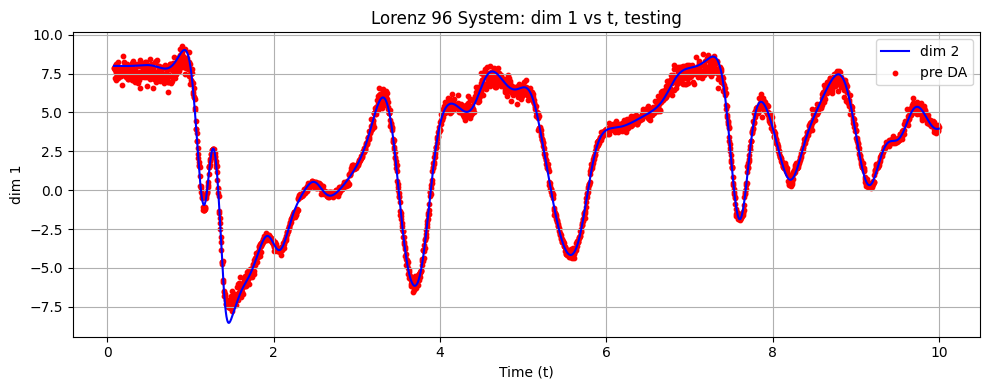

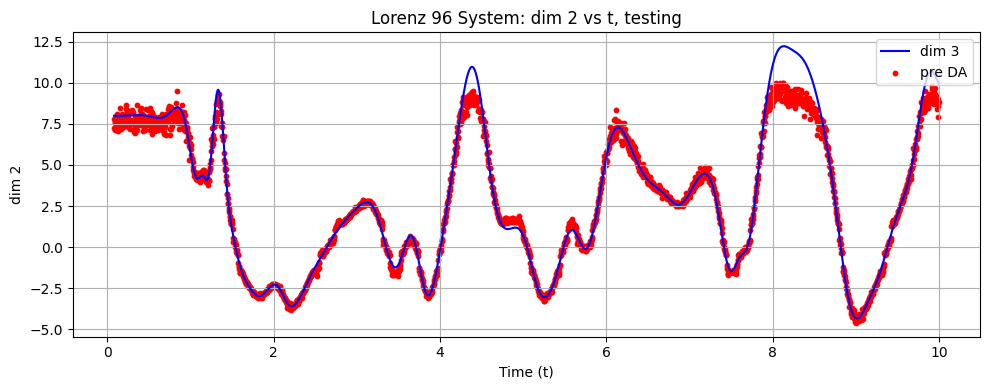

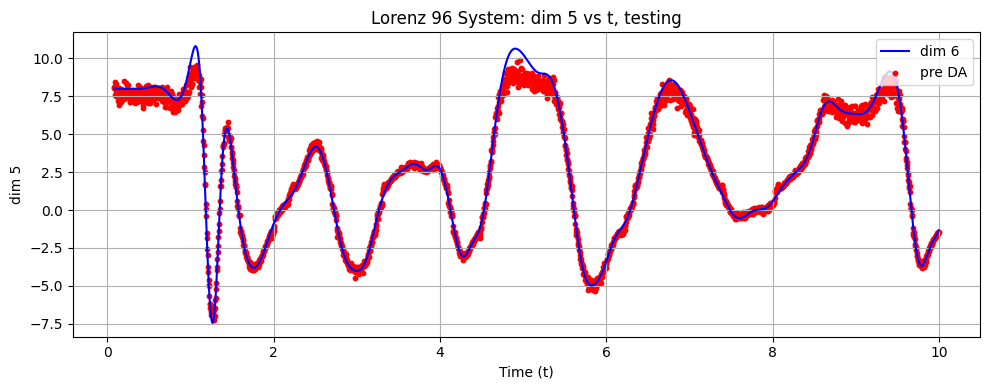

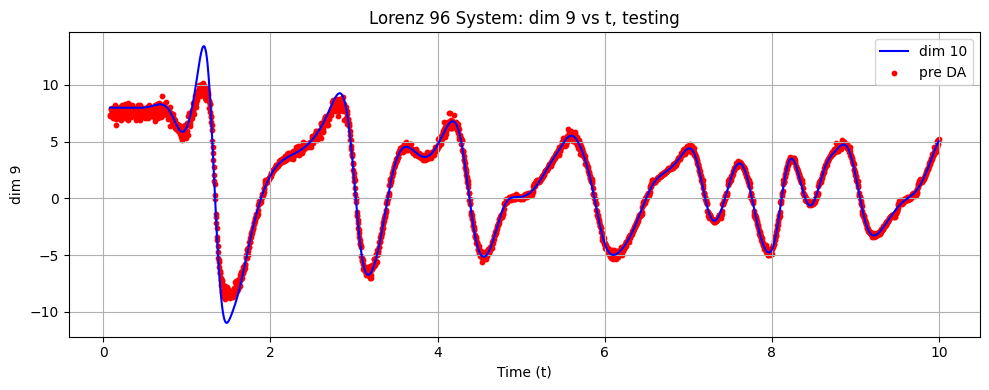

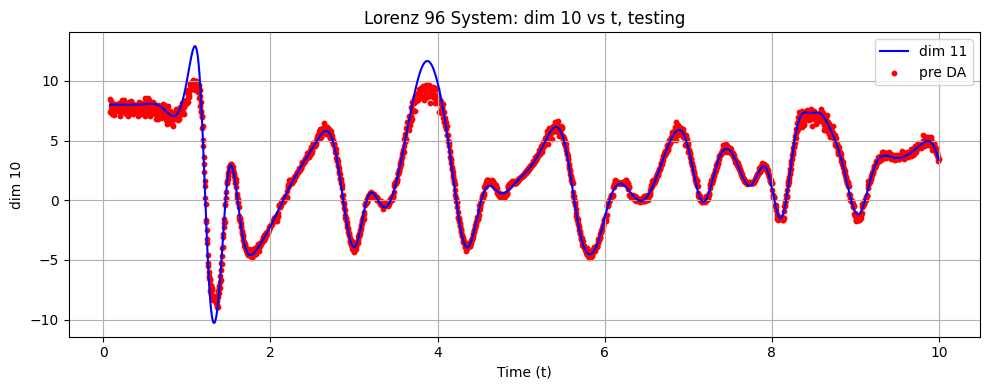

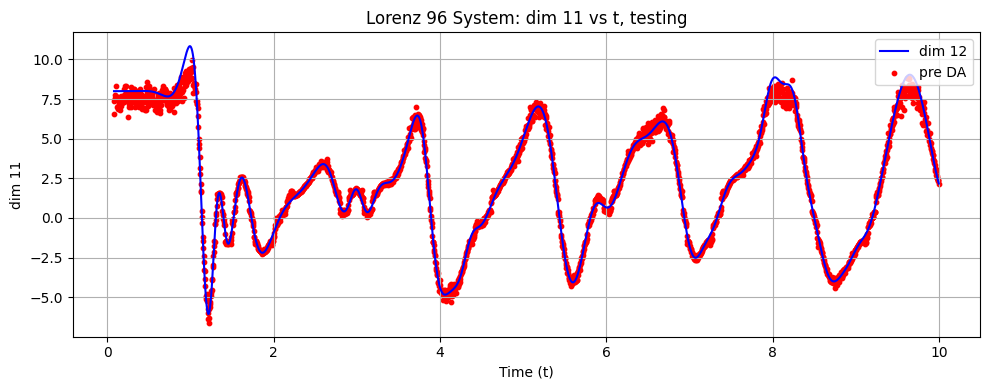

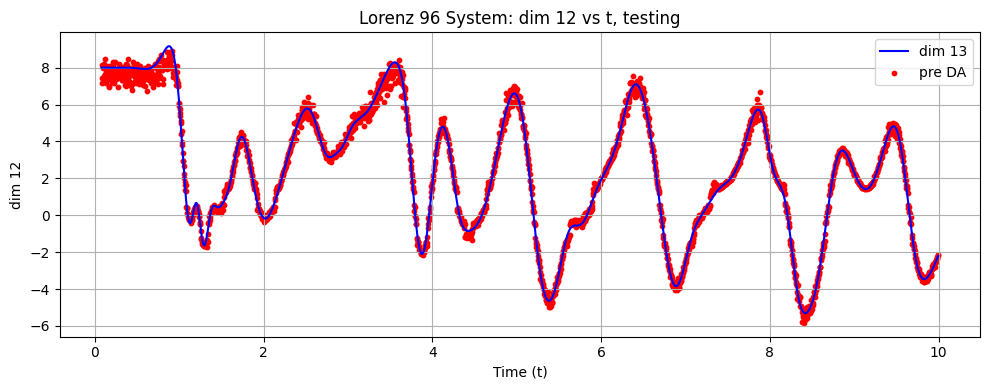

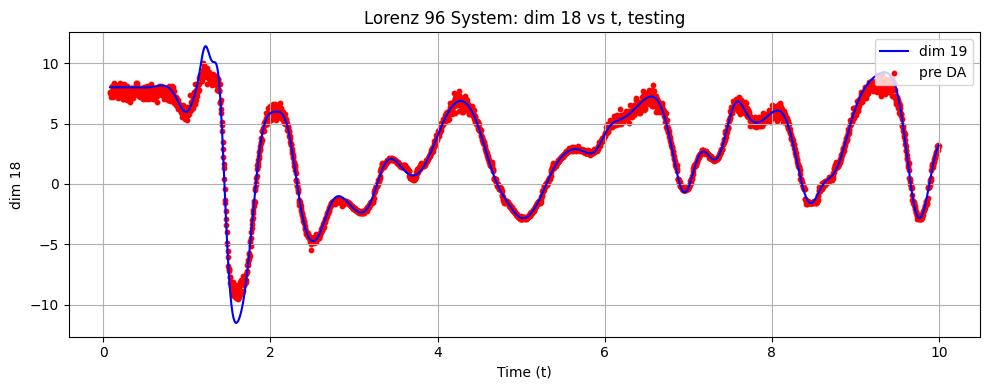

In [18]:
rr = np.array(x_states)
for i in range(dim_x):
    if_plot = np.random.randint(2)
    if if_plot:
        plt.figure(figsize = (10, 4))
        plt.plot(t[LSTM_seq_len: ], sol[LSTM_seq_len: , i], label = 'dim ' + str(i + 1), color = 'blue')
        plt.scatter(t[LSTM_seq_len: ], rr[:, i], label = 'pre DA', color = 'red', s = 10)
        #plt.plot(t[LSTM_seq_len: ], rr[:, i], label = 'pre DA', color = 'red')
        '''for j in range(t[LSTM_seq_len: ].shape[0] // obs_gap):
            if j % 2 == 0:
                plt.scatter(t[LSTM_seq_len + j * obs_gap: LSTM_seq_len + j * obs_gap + obs_gap], 
                            rr[LSTM_seq_len + j * obs_gap: LSTM_seq_len + j * obs_gap + obs_gap, i], 
                            color = 'red')
            else:
                plt.scatter(t[LSTM_seq_len + j * obs_gap: LSTM_seq_len + j * obs_gap + obs_gap], 
                            rr[LSTM_seq_len + j * obs_gap: LSTM_seq_len + j * obs_gap + obs_gap, i], 
                            color = 'yellow')
        if t[LSTM_seq_len: ].shape[0] % obs_gap: 
            temp_plt_reminder = t[LSTM_seq_len: ].shape[0] % obs_gap
            plt.scatter(t[-1 * temp_plt_reminder: ], rr[-1 * temp_plt_reminder: , i], color = 'black')'''
        plt.title("Lorenz 96 System: dim " + str(i) + " vs t, testing")
        plt.xlabel("Time (t)")
        plt.ylabel("dim " + str(i))
        plt.grid(True)
        plt.legend(loc = "upper right")
        plt.tight_layout()
        plt.show()

In [19]:
model.eval()

LSTMModel(
  (lstm): LSTM(20, 128, num_layers=5, batch_first=True)
  (fc): Linear(in_features=128, out_features=20, bias=True)
)

In [20]:
x_state_std = np.array(x_state_std)
x_state_std.shape

(2480, 20)

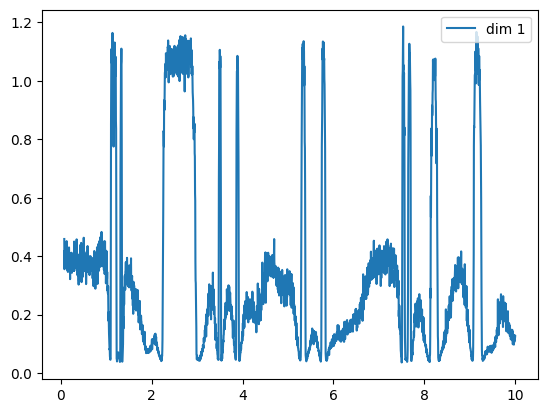

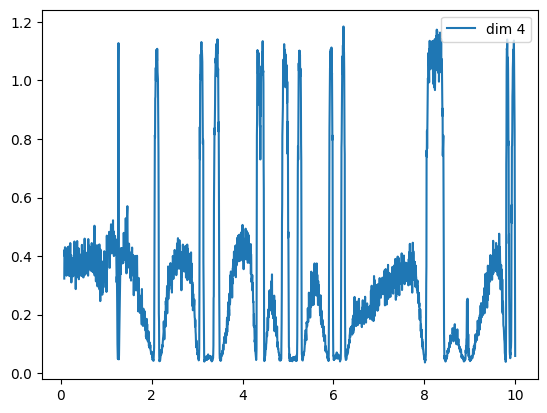

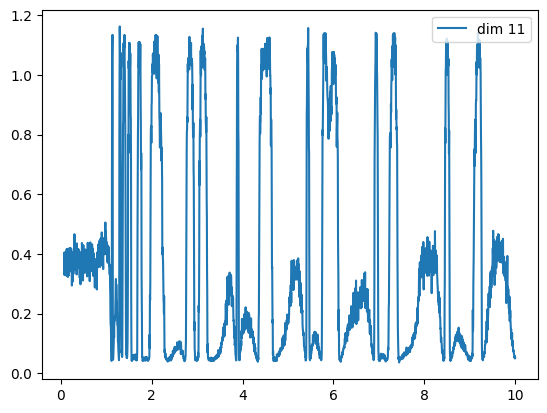

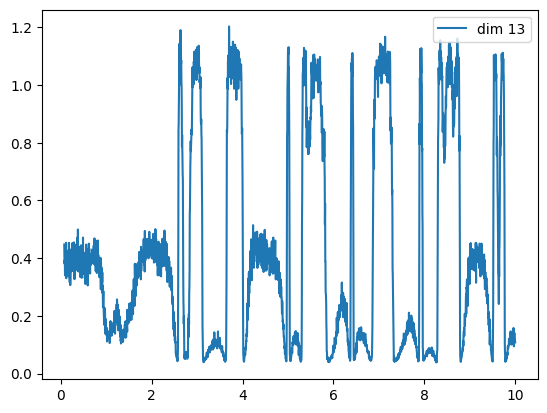

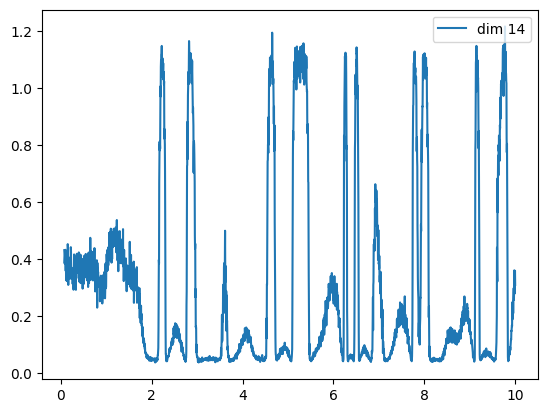

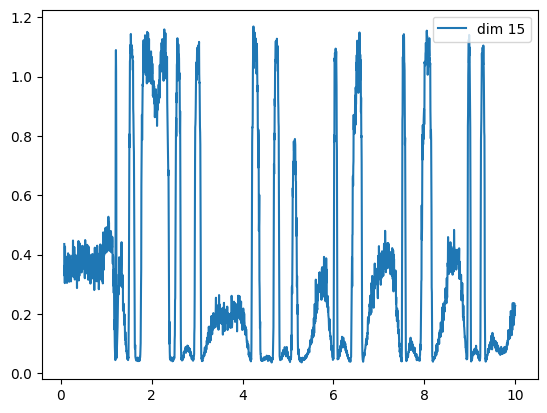

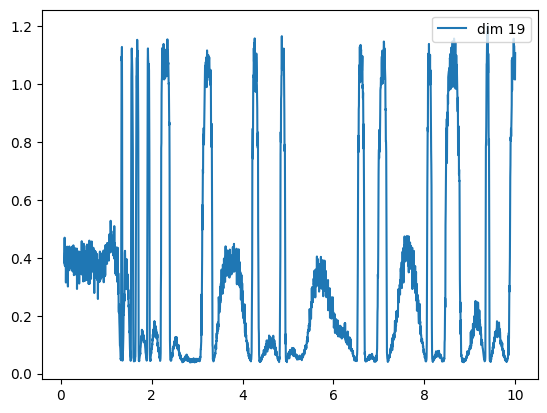

In [21]:
for i in range(x_state_std.shape[1]):
    if_plot = np.random.randint(2)
    if if_plot:
        plt.plot(t[LSTM_seq_len: ], x_state_std[: , i], label = 'dim ' + str(i))
        plt.legend(loc = 'upper right')
        plt.show()

In [22]:
temp_input, temp_output = create_data(sol, LSTM_seq_len, device)

In [23]:
model(temp_input[0: 1] + torch.randn_like(temp_input[0: 1]) * initial_state_std)

tensor([[7.0381, 5.9649, 8.1481, 8.8667, 9.1162, 9.6464, 5.3342, 6.5015, 9.0851,
         7.2000, 7.6743, 6.9678, 7.6618, 9.1768, 6.5994, 5.0274, 7.1337, 6.1397,
         8.2695, 9.1578]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [24]:
temp_output[0]

tensor([8.0080, 7.9963, 7.9945, 8.0012, 8.0018, 7.9997, 7.9996, 8.0000, 8.0001,
        8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0000, 8.0001, 8.0004,
        8.0018, 8.0057], device='cuda:0')

In [25]:
fifo_x = []
for i in range(0, sol.shape[0] - LSTM_seq_len):
    fifo_x.append(sol[i: i + 20, :])

In [26]:
fifo_x = np.array(fifo_x, dtype = np.float32)

In [27]:
fifo_x = torch.from_numpy(fifo_x).to(device)

In [28]:
fifo_y = model(fifo_x).cpu().detach().numpy()

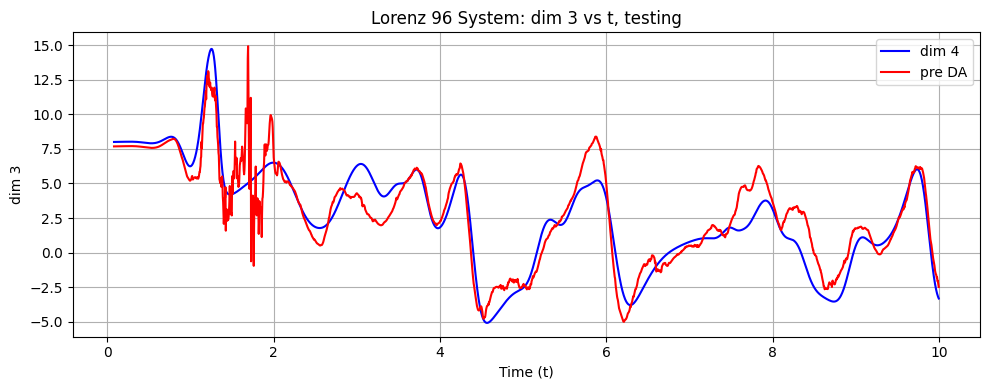

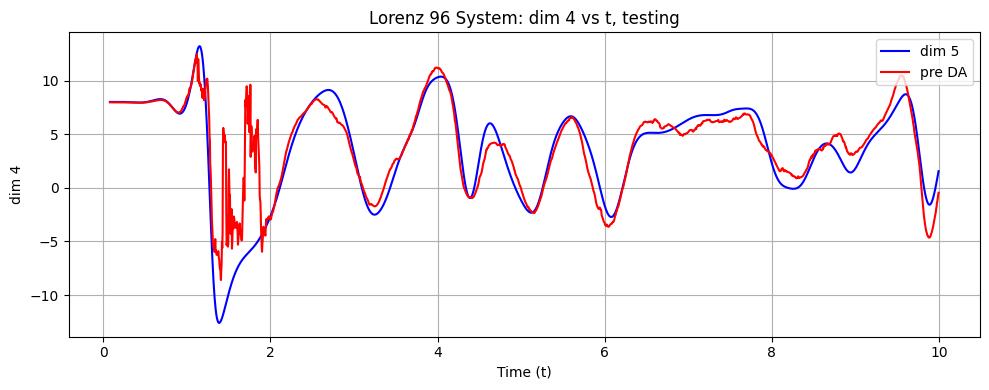

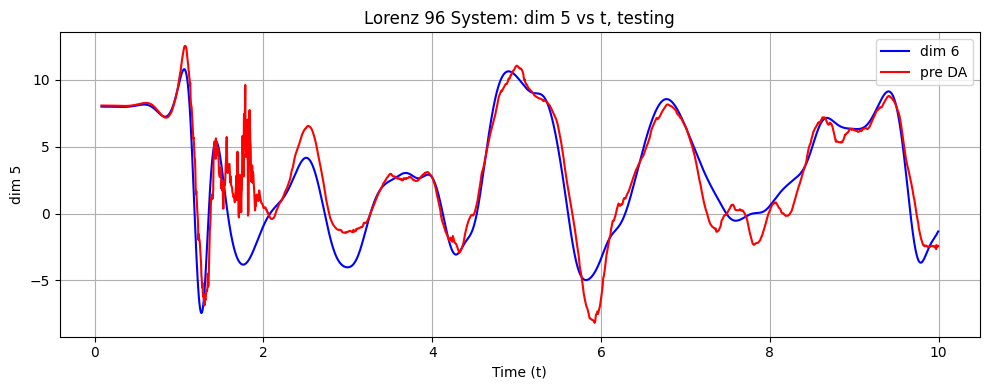

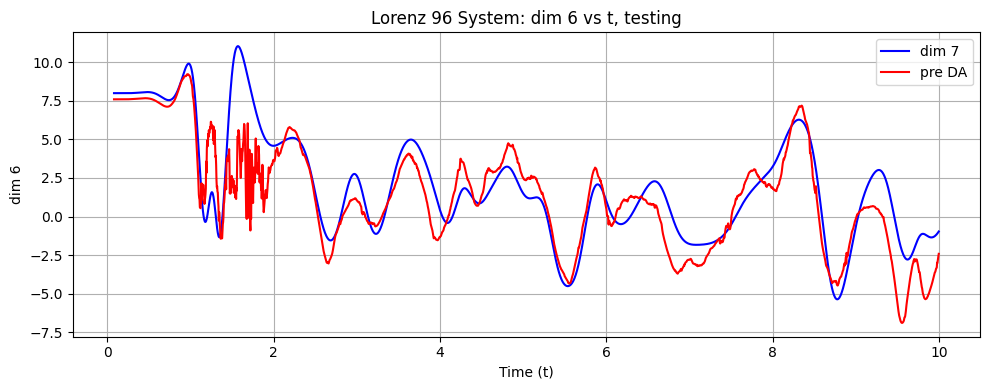

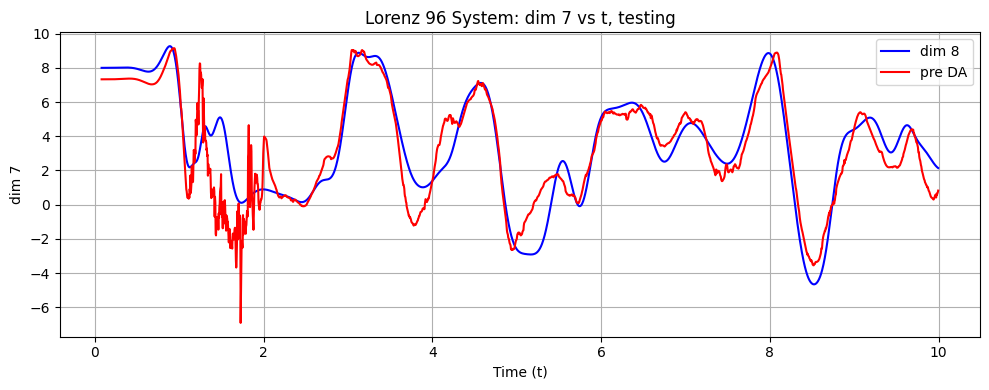

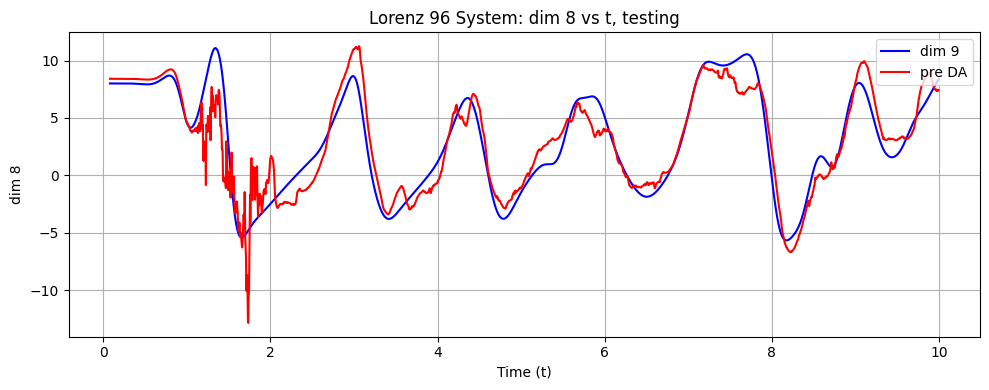

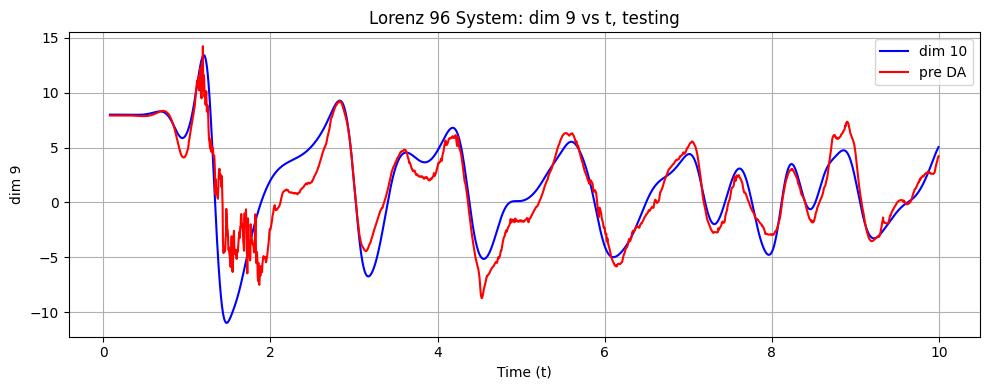

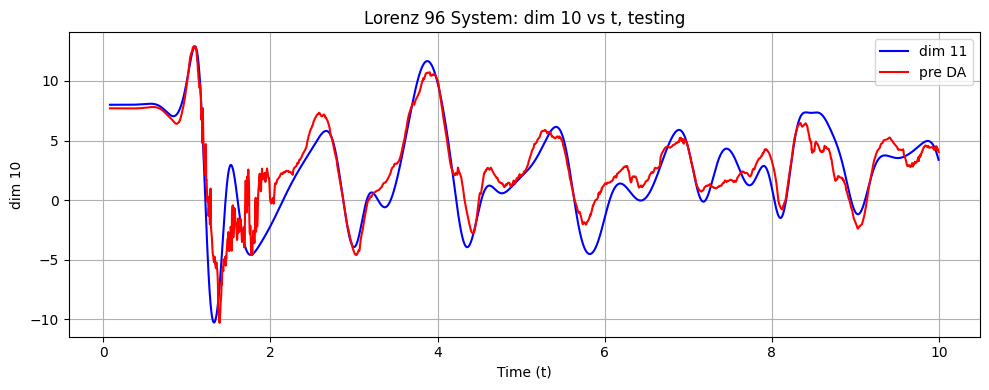

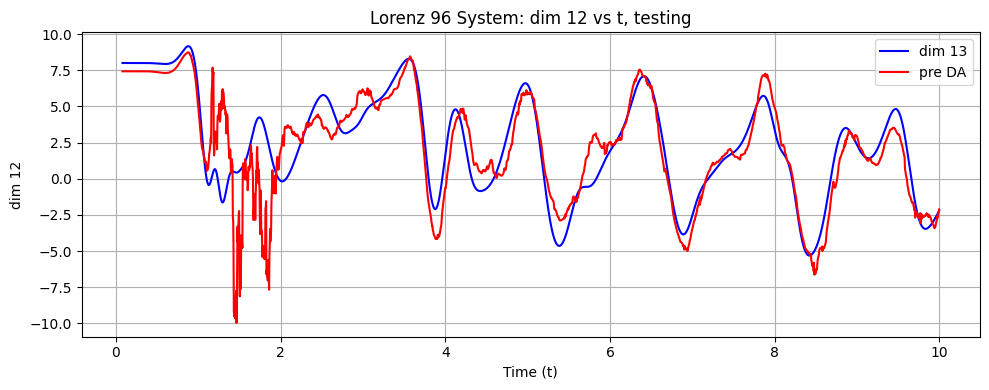

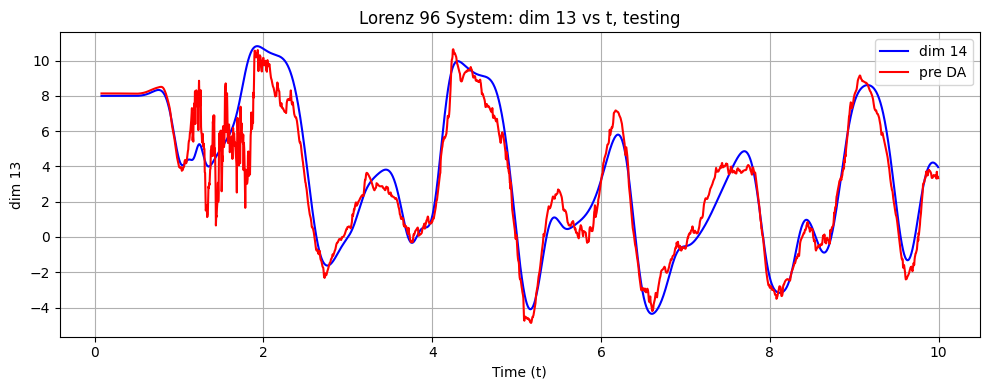

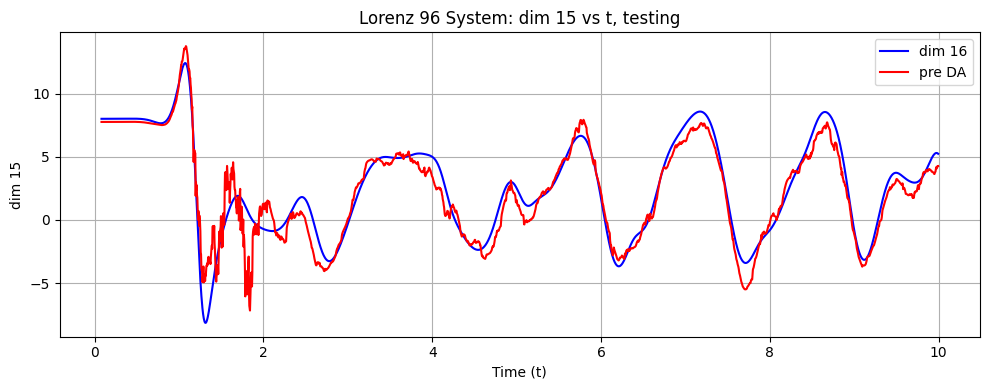

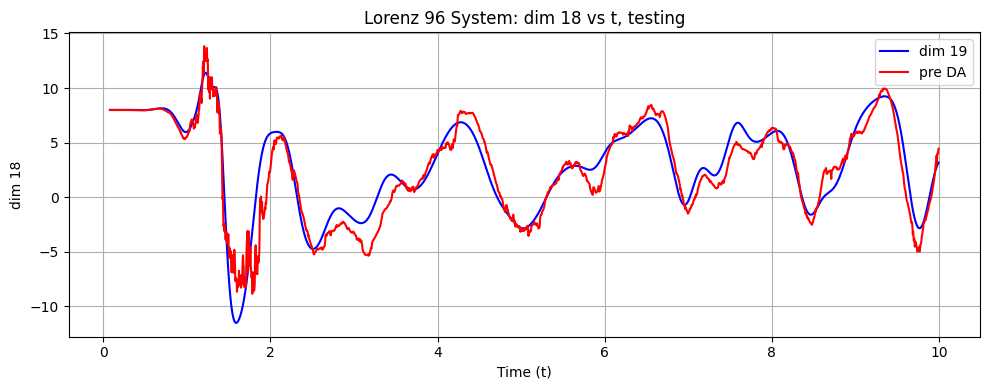

In [29]:
for i in range(dim_x):
    if_plot = np.random.randint(2)
    if if_plot:
        plt.figure(figsize = (10, 4))
        plt.plot(t[LSTM_seq_len: ], sol[LSTM_seq_len: , i], label = 'dim ' + str(i + 1), color = 'blue')
        #plt.scatter(t[LSTM_seq_len: ], fifo_y[:, i], label = 'pre DA', color = 'red')
        plt.plot(t[LSTM_seq_len: ], fifo_y[:, i], label = 'pre DA', color = 'red')
        plt.title("Lorenz 96 System: dim " + str(i) + " vs t, testing")
        plt.xlabel("Time (t)")
        plt.ylabel("dim " + str(i))
        plt.grid(True)
        plt.legend(loc = "upper right")
        plt.tight_layout()
        plt.show()

In [30]:
def push_to_tensor_alternative(tensor, x):
    return torch.cat((tensor[1:], x.view(1, 1, dim_x)))

In [31]:
x_fifo = fifo_x[0].view(1, 20, dim_x)
x_fifo.shape

torch.Size([1, 20, 20])

In [32]:
model(x_fifo)

tensor([[8.2597, 8.0749, 8.5176, 7.6785, 7.9621, 8.0830, 7.6005, 7.3292, 8.4082,
         7.9186, 7.7024, 7.7313, 7.4265, 8.1381, 6.6839, 7.7521, 7.2560, 7.8553,
         7.9846, 9.0225]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [33]:
model(x_fifo).view(1, 1, dim_x)

tensor([[[8.2597, 8.0749, 8.5176, 7.6785, 7.9621, 8.0830, 7.6005, 7.3292,
          8.4082, 7.9186, 7.7024, 7.7313, 7.4265, 8.1381, 6.6839, 7.7521,
          7.2560, 7.8553, 7.9846, 9.0225]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [34]:
y_fifo = []
for i in range(total_data_size - LSTM_seq_len):
    temp = model(x_fifo)
    y_fifo.append(copy.deepcopy(temp.view(-1).cpu().detach().numpy()))
    x_fifo = torch.cat((x_fifo[:, 1:, :], temp.view(1, 1, dim_x)), dim = 1)
    #x_fifo = torch.cat((x_fifo[:, 1:, :], copy.deepcopy(temp.view(1, 1, dim_x))), dim = 1)

In [35]:
y_fifo = np.array(y_fifo)
y_fifo.shape

(2480, 20)

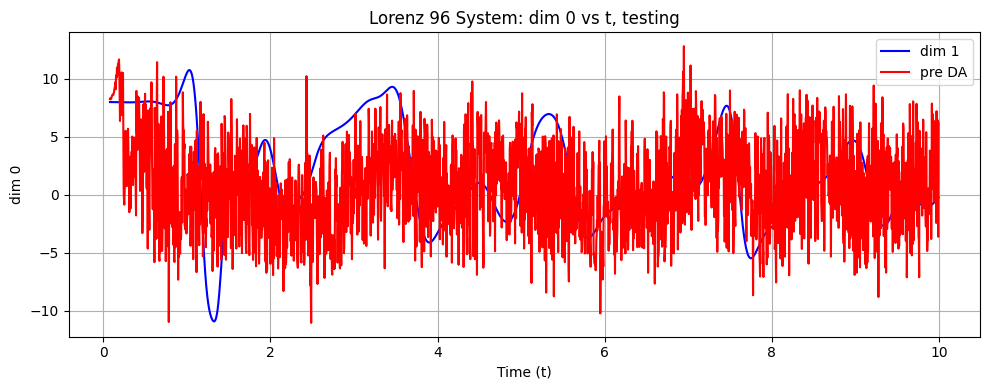

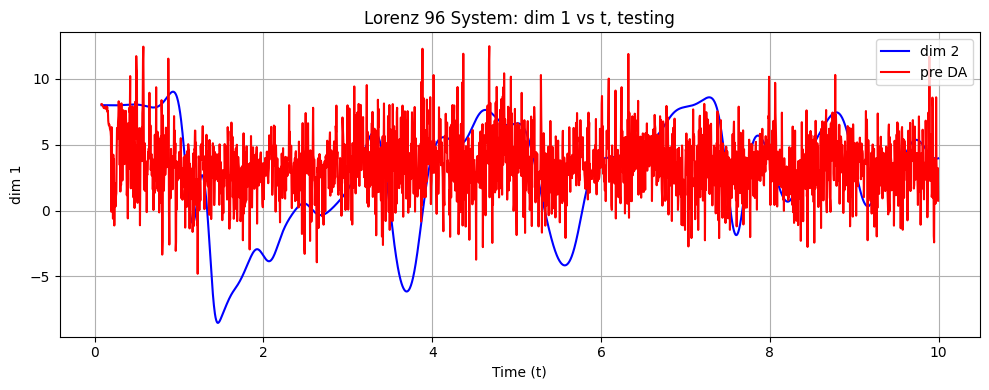

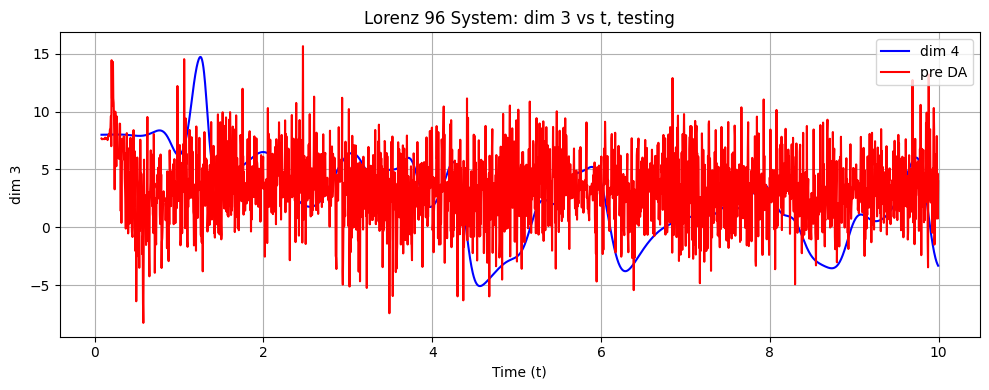

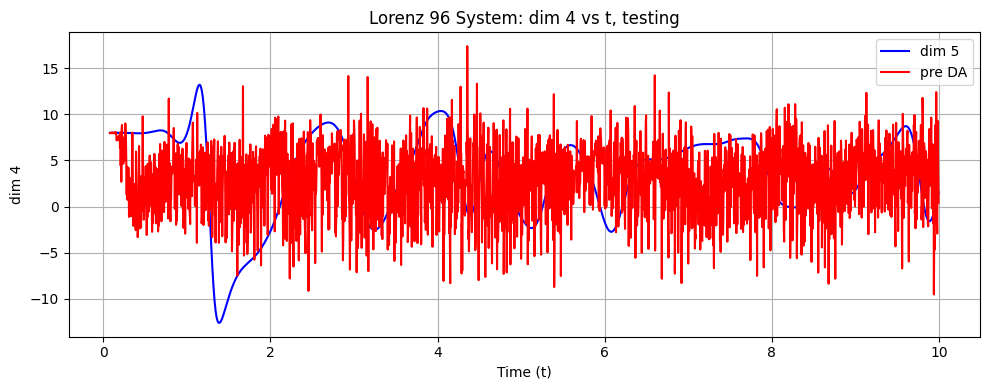

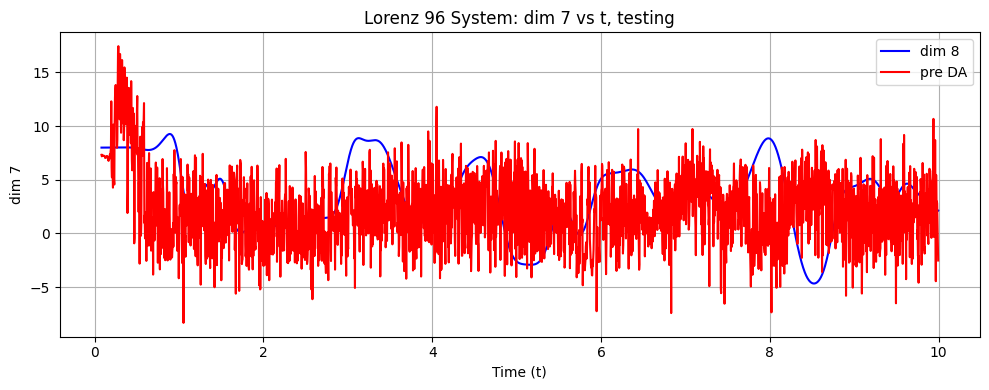

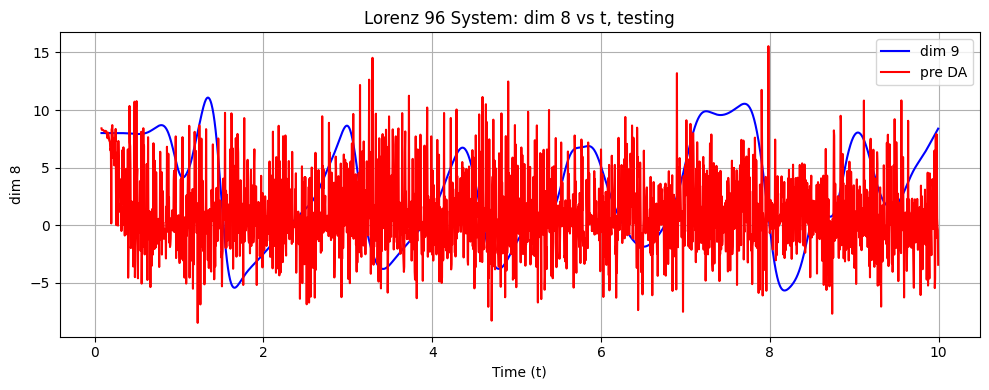

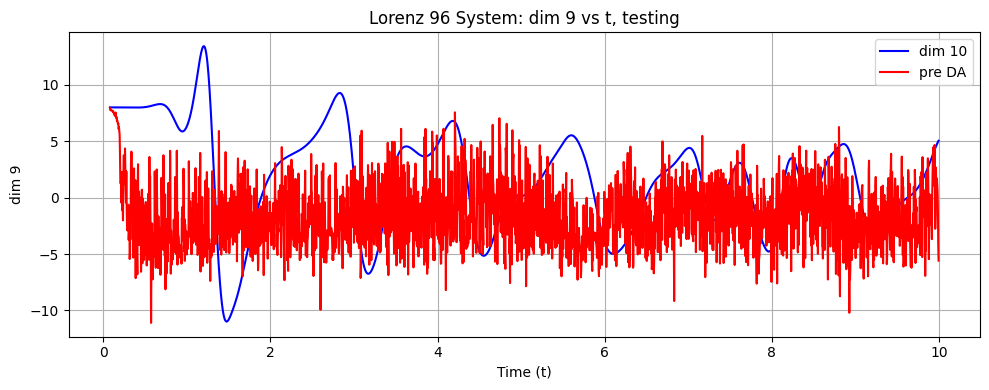

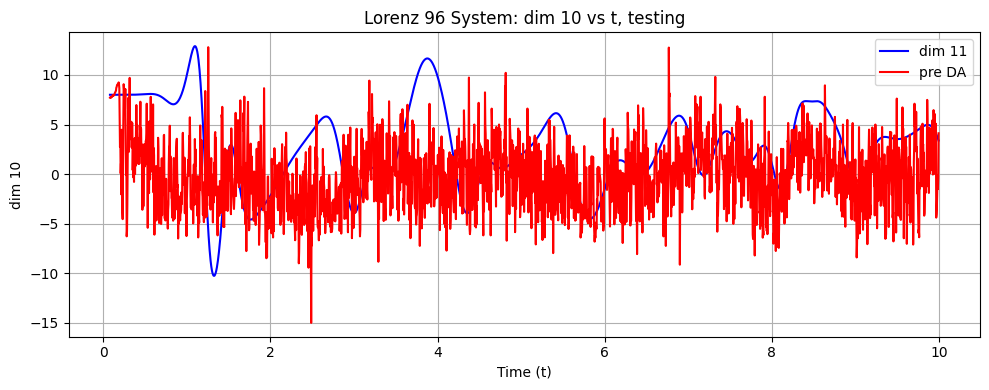

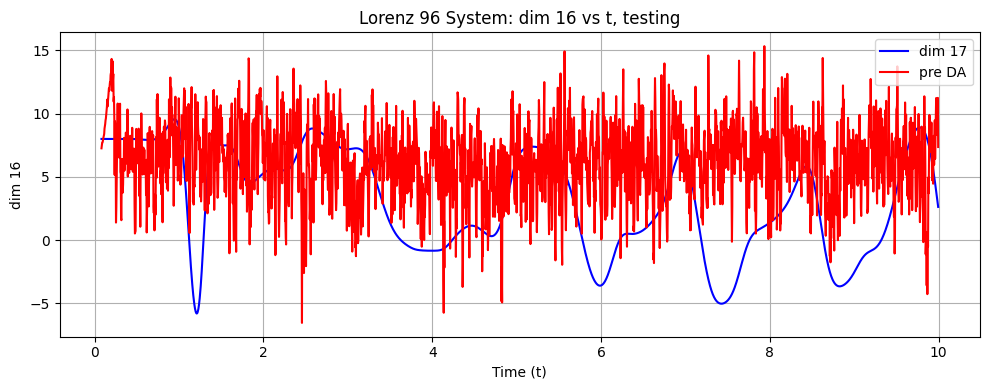

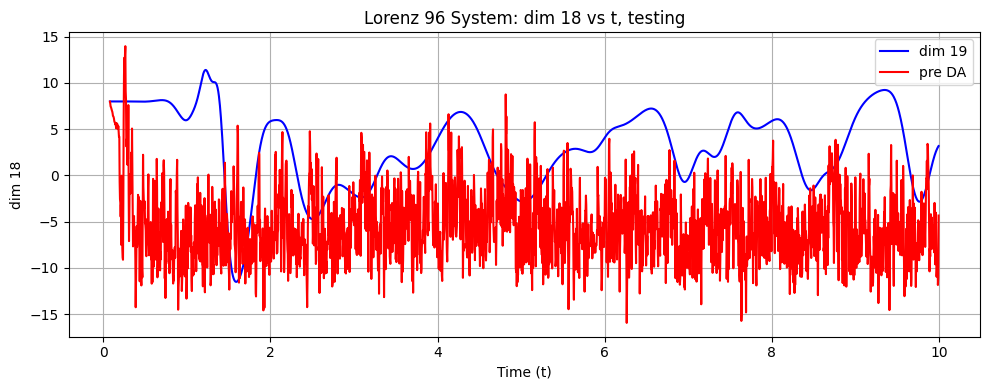

In [36]:
for i in range(dim_x):
    if_plot = np.random.randint(2)
    if if_plot:
        plt.figure(figsize = (10, 4))
        plt.plot(t[LSTM_seq_len: ], sol[LSTM_seq_len: , i], label = 'dim ' + str(i + 1), color = 'blue')
        #plt.scatter(t[LSTM_seq_len: ], y_fifo[:, i], label = 'pre DA', color = 'red')
        plt.plot(t[LSTM_seq_len: ], y_fifo[:, i], label = 'pre DA', color = 'red')
        plt.title("Lorenz 96 System: dim " + str(i) + " vs t, testing")
        plt.xlabel("Time (t)")
        plt.ylabel("dim " + str(i))
        plt.grid(True)
        plt.legend(loc = "upper right")
        plt.tight_layout()
        plt.show()

In [37]:
loss_fn(torch.from_numpy(rr), torch.from_numpy(sol[LSTM_seq_len: , :])) # EnSF

tensor(0.2604, dtype=torch.float64)

In [38]:
loss_fn(torch.from_numpy(y_fifo), torch.from_numpy(sol[LSTM_seq_len: , :])) # FIFO only

tensor(39.2190, dtype=torch.float64)

In [39]:
loss_fn(torch.from_numpy(fifo_y), torch.from_numpy(sol[LSTM_seq_len: , :])) # LSTM with true input

tensor(2.8975, dtype=torch.float64)

In [40]:
loss_fn(torch.from_numpy(fifo_y), torch.from_numpy(rr)) # EnSF vs LSTM with true input

tensor(2.7168)

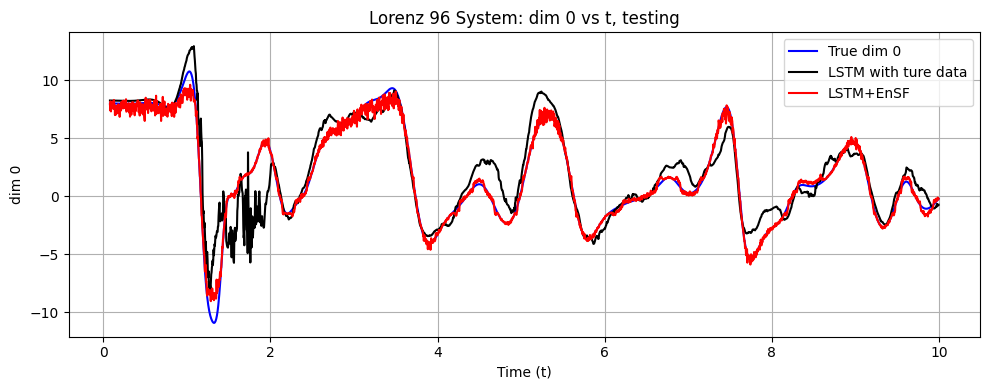

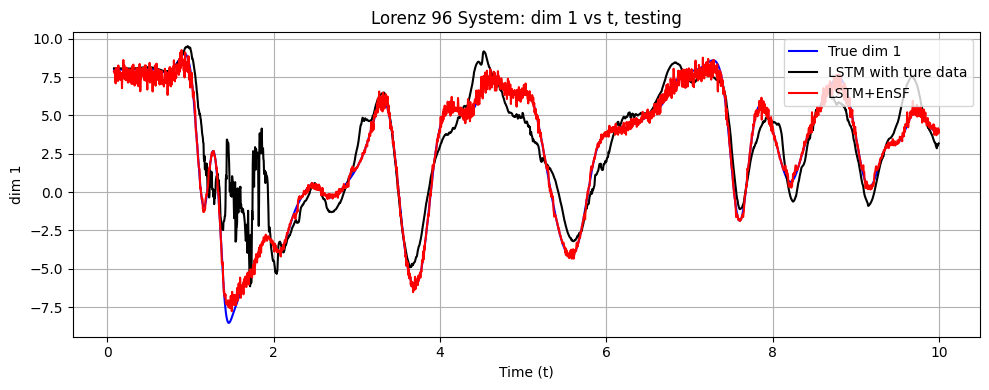

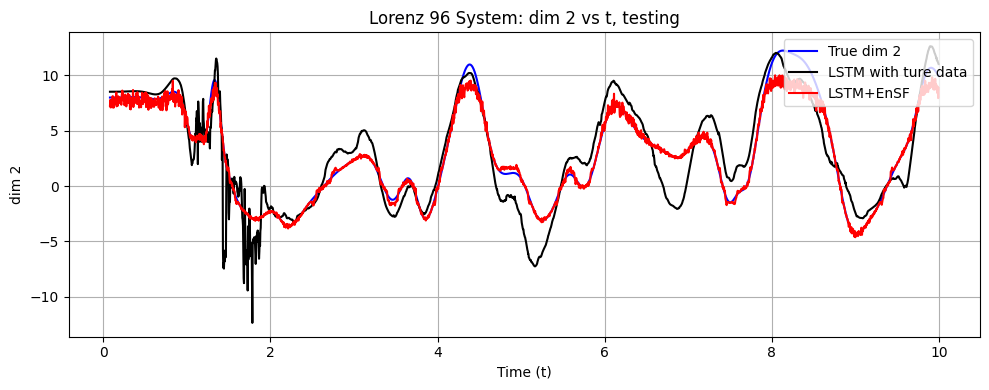

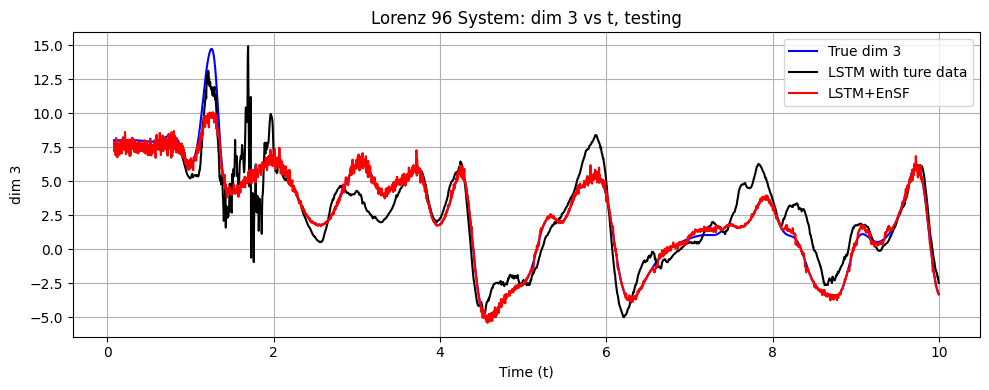

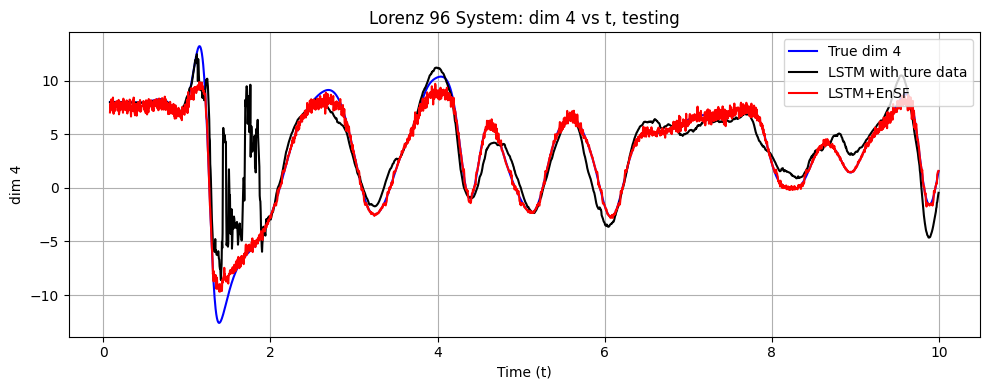

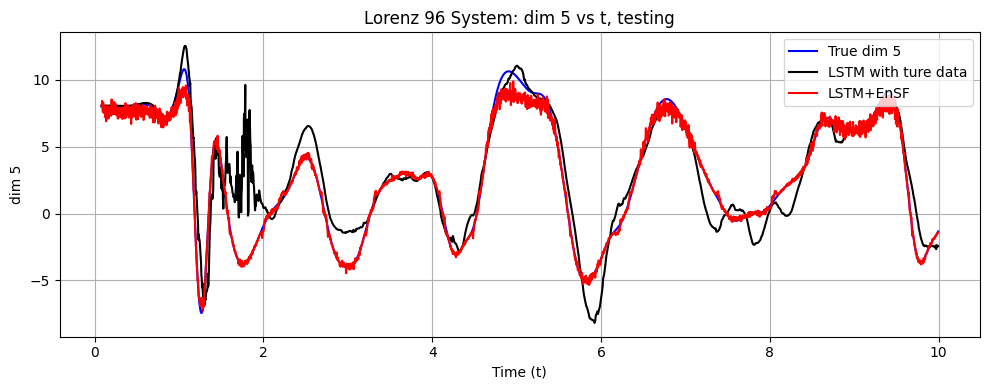

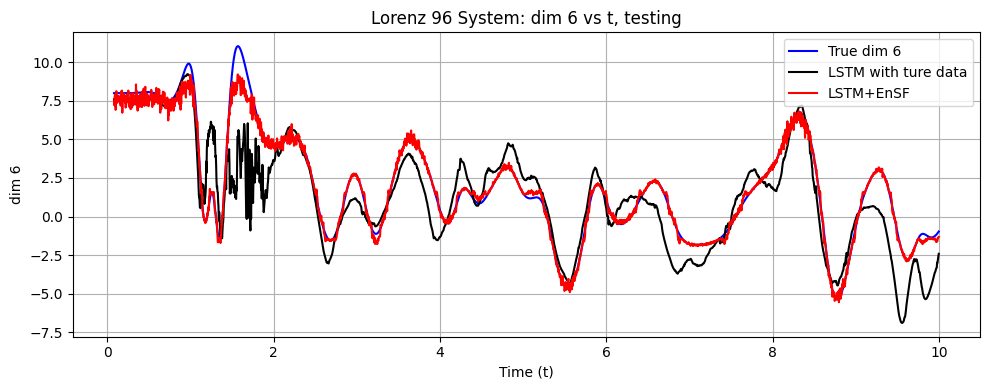

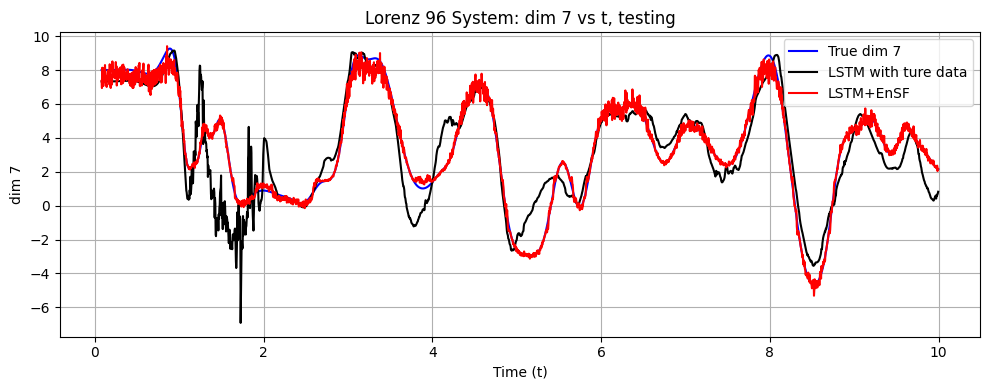

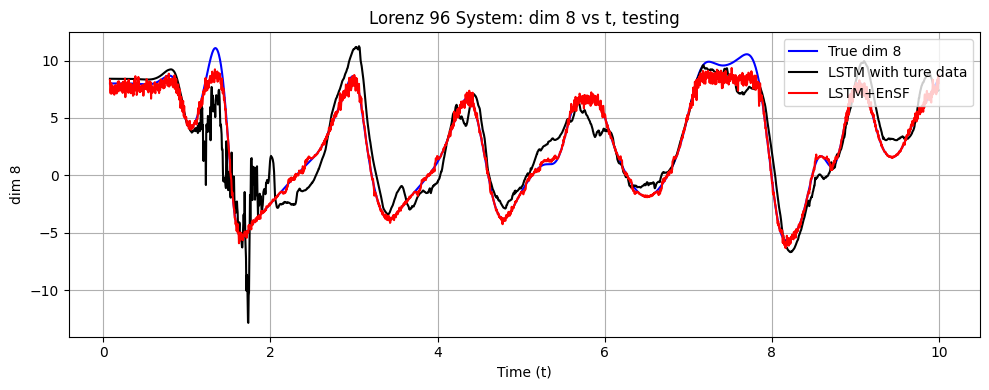

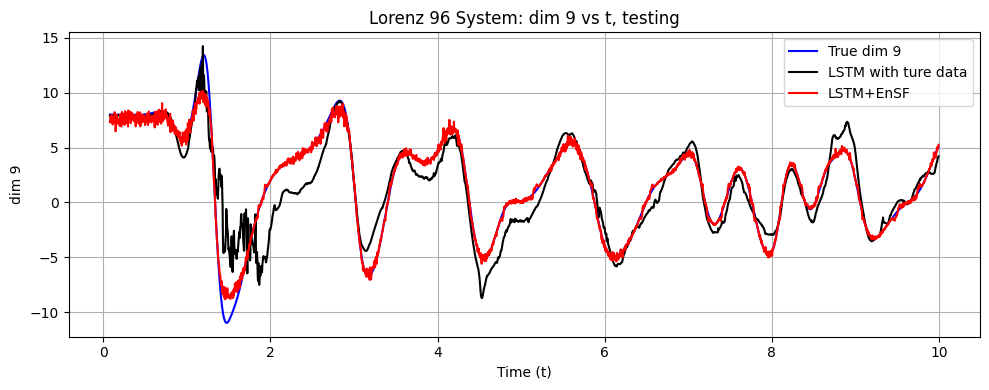

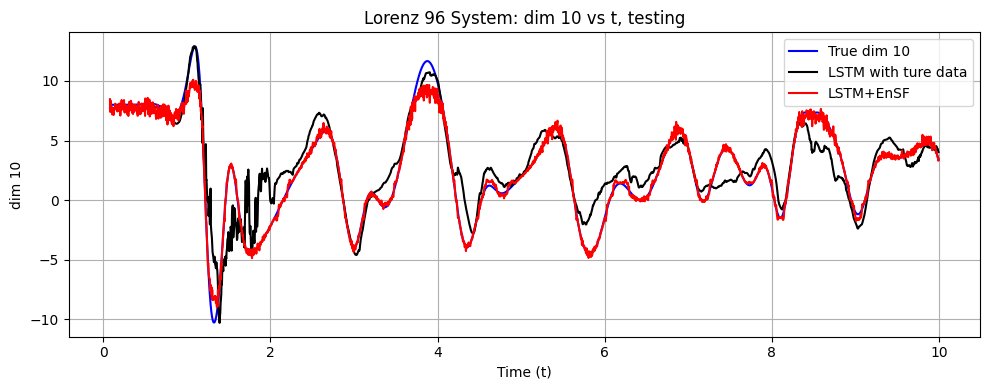

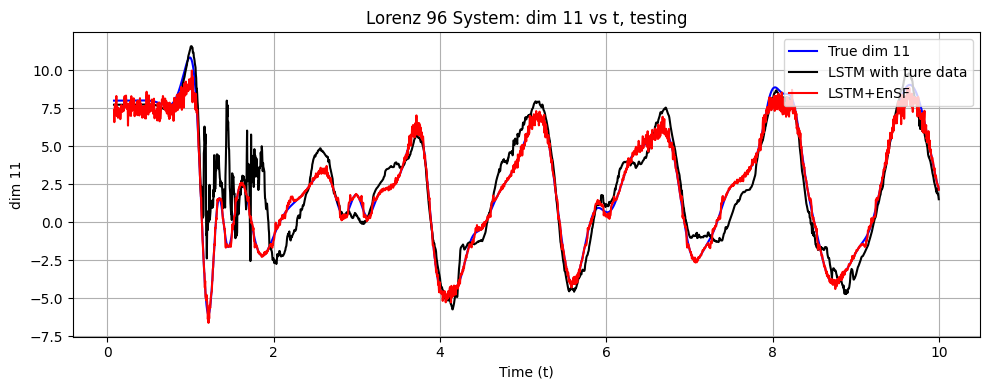

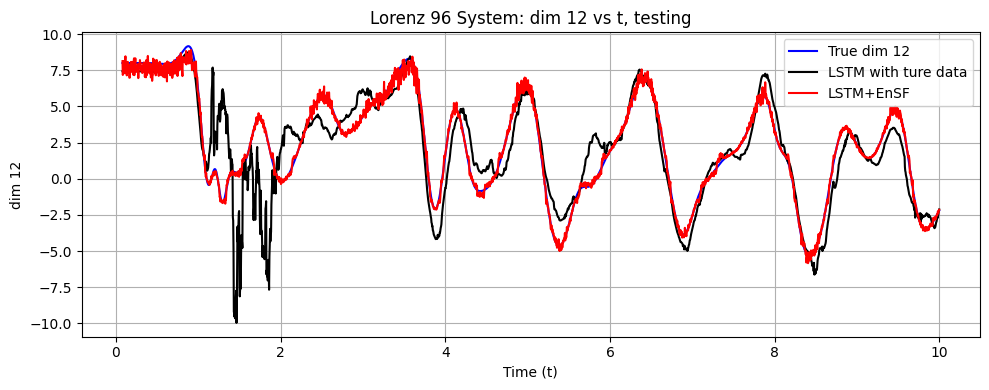

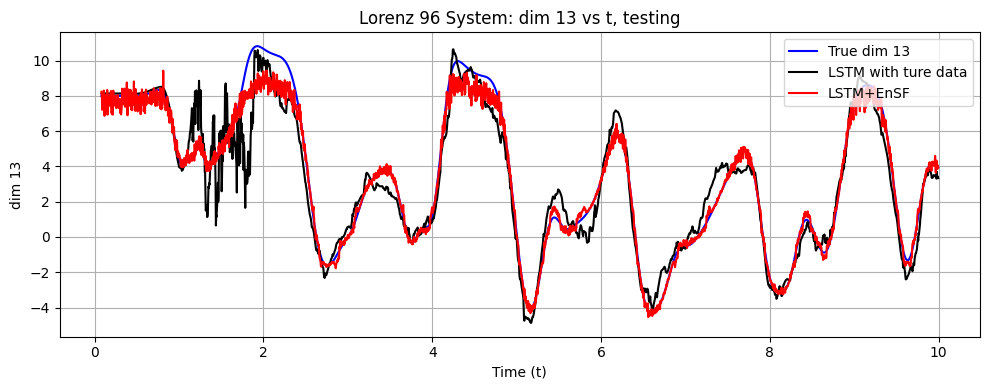

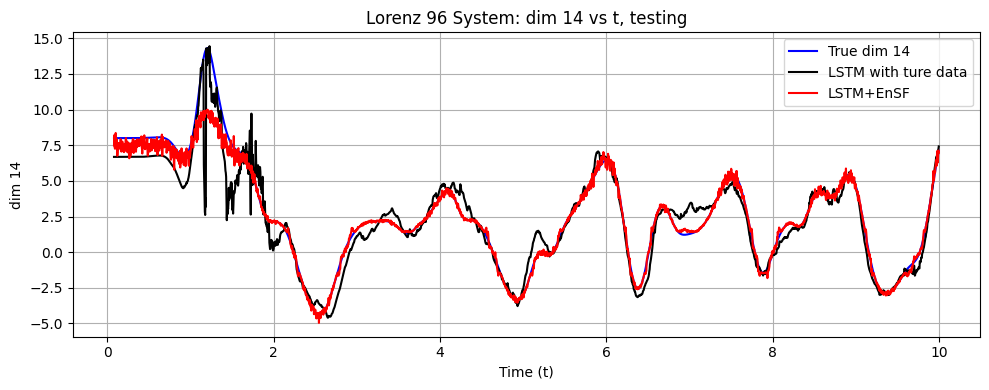

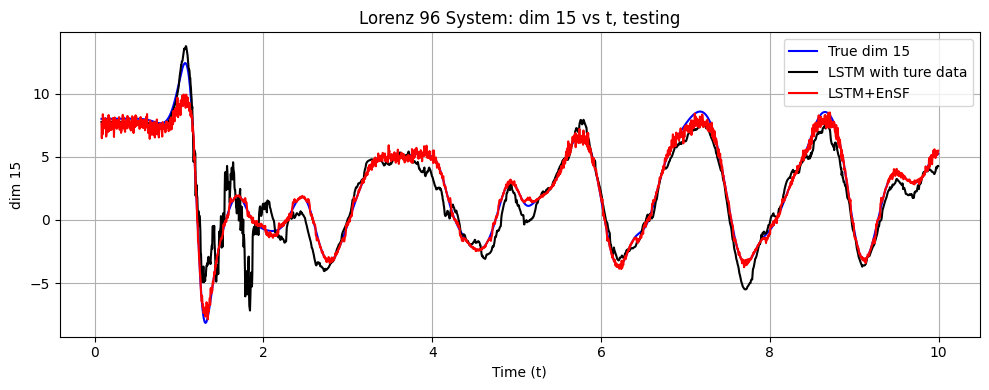

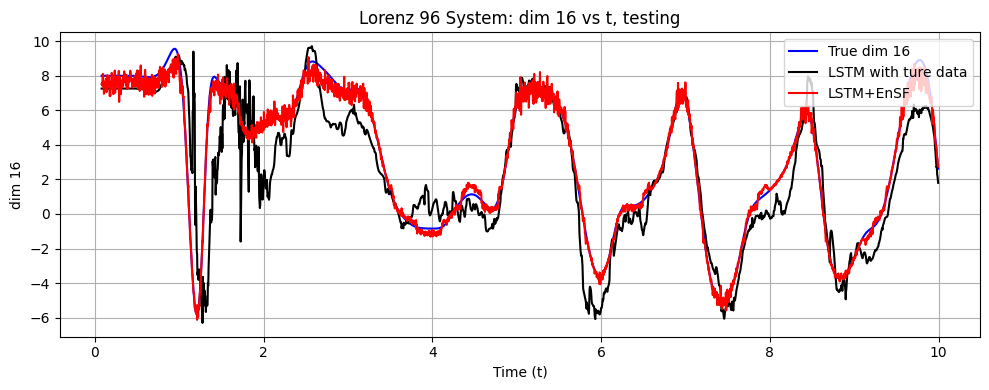

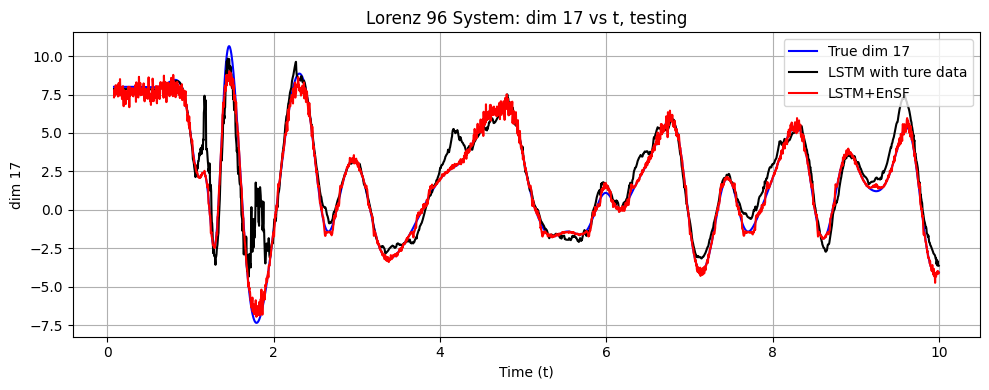

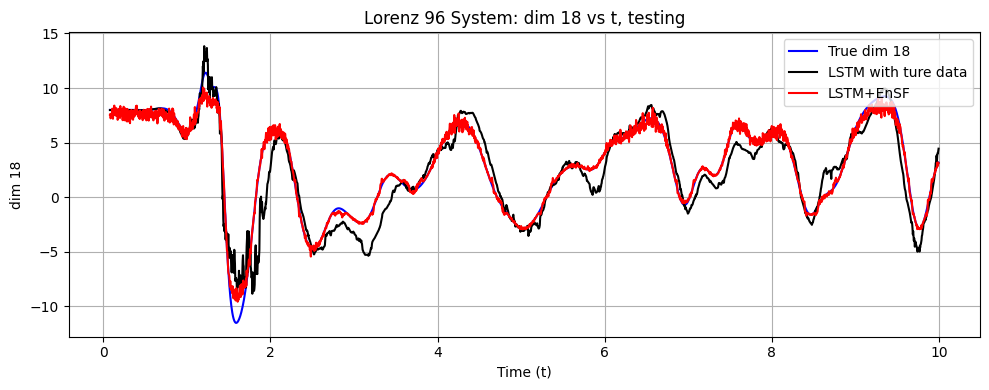

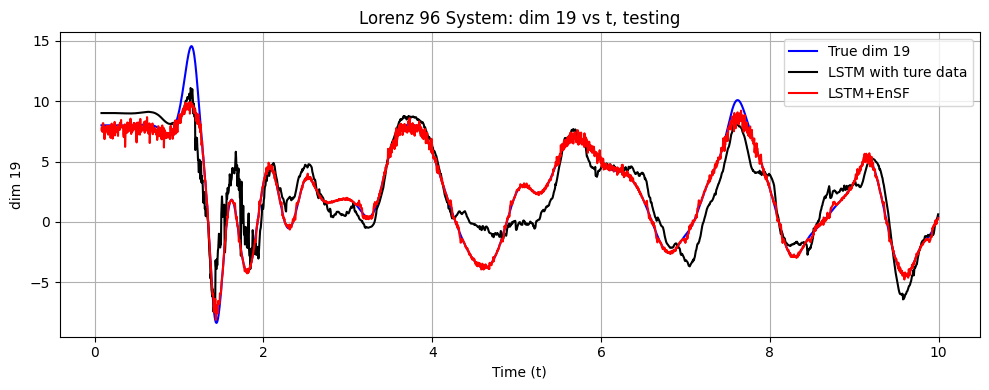

In [43]:
for i in range(dim_x):
    if_plot = 1#np.random.randint(2)
    if if_plot:
        plt.figure(figsize = (10, 4))
        plt.plot(t[LSTM_seq_len: ], sol[LSTM_seq_len: , i], label = 'True dim ' + str(i), color = 'blue')
        #plt.scatter(t[LSTM_seq_len: ], y_fifo[:, i], label = 'pre DA', color = 'red')
        plt.plot(t[LSTM_seq_len: ], fifo_y[:, i], label = 'LSTM with ture data', color = 'black')
        plt.plot(t[LSTM_seq_len: ], rr[:, i], label = 'LSTM+EnSF', color = 'red')
        plt.title("Lorenz 96 System: dim " + str(i) + " vs t, testing")
        plt.xlabel("Time (t)")
        plt.ylabel("dim " + str(i))
        plt.grid(True)
        plt.legend(loc = "upper right")
        plt.tight_layout()
        plt.show()

In [40]:
x_fifo = fifo_x[0].view(1, 20, dim_x).float()
x_fifo = x_fifo + torch.randn_like(x_fifo) * initial_state_std
y_fifo_obs = []
do_obs = 0
for i in range(LSTM_seq_len, total_data_size):
    if i % obs_gap == 0:
        do_obs = consecutive_obs

    if do_obs:
        do_obs = do_obs - 1
        temp = torch.atan(torch.from_numpy(sol[i - 1]).to(device).float())
        temp = temp + torch.randn_like(temp) * obs_sigma
        temp = torch.clamp(temp, min = math.atan(-15.0), max = math.atan(15.0))
        temp = torch.tan(temp)
    else: 
        temp = model(x_fifo)
        temp = temp + torch.randn_like(temp) * forward_error
    y_fifo_obs.append(copy.deepcopy(temp.view(-1).cpu().detach().numpy()))
    x_fifo = torch.cat((x_fifo[:, 1:, :], temp.view(1, 1, dim_x)), dim = 1)
y_fifo_obs = np.array(y_fifo_obs)

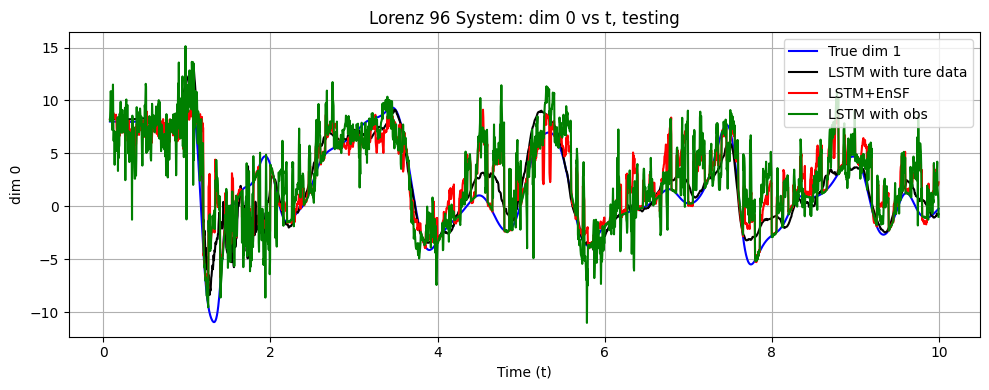

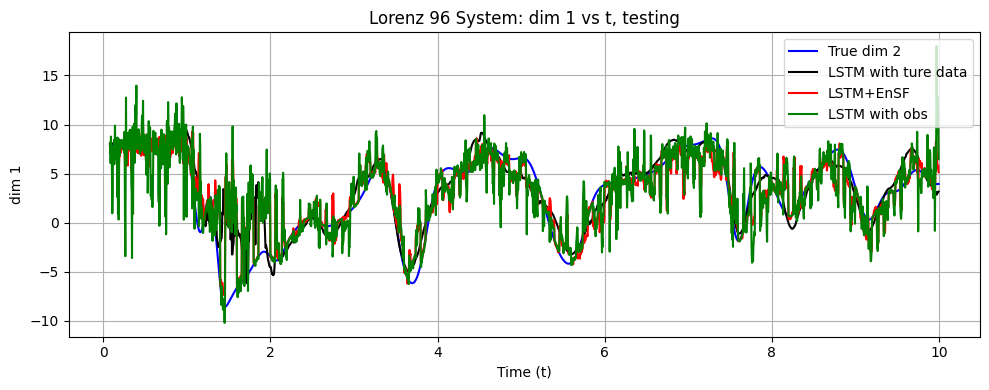

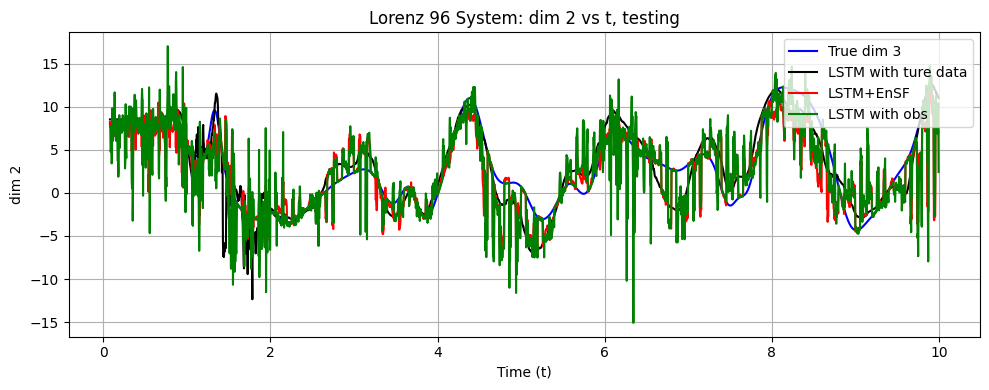

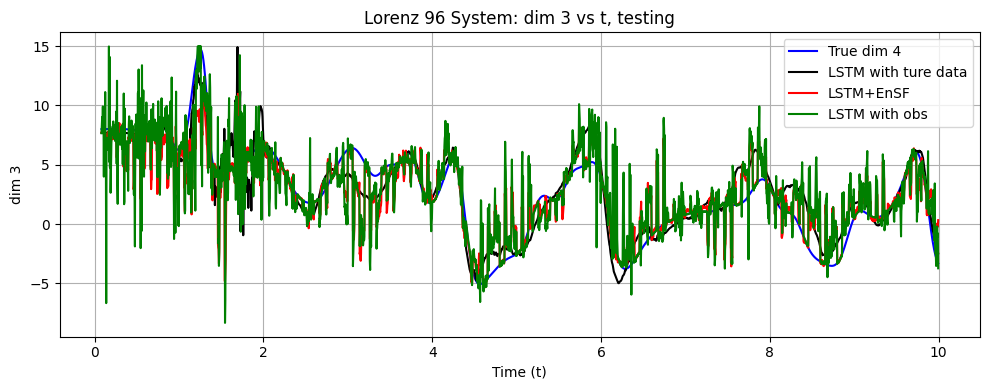

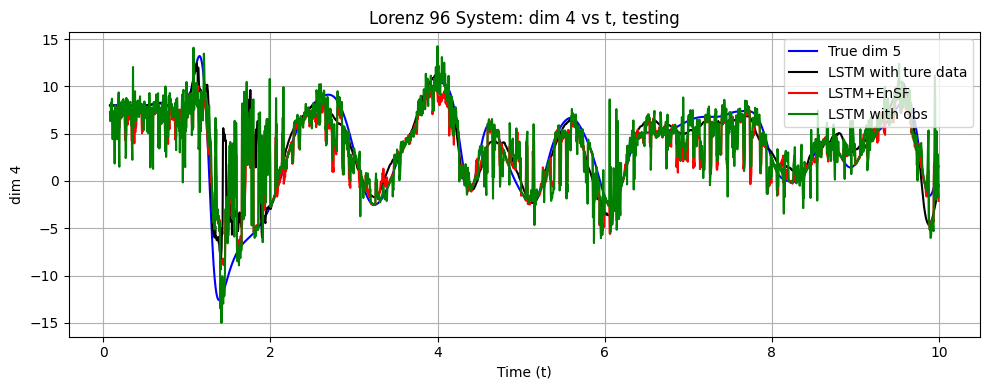

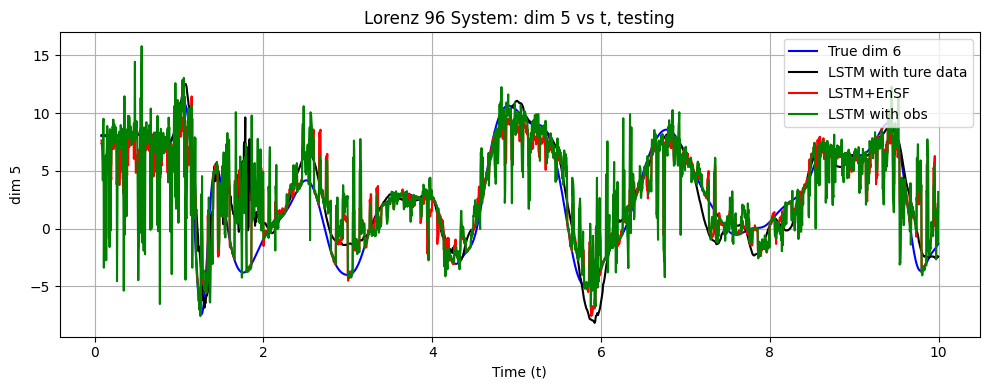

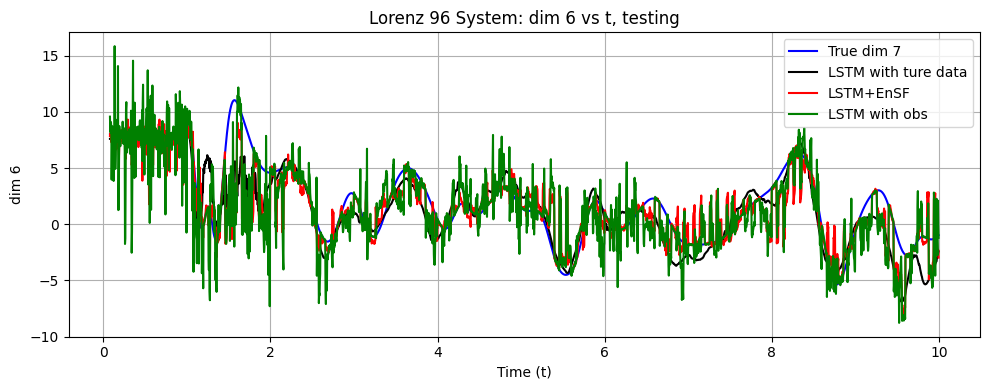

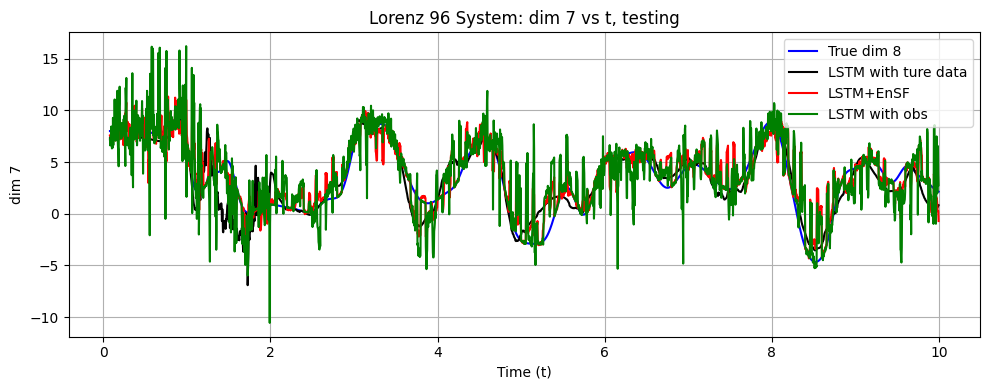

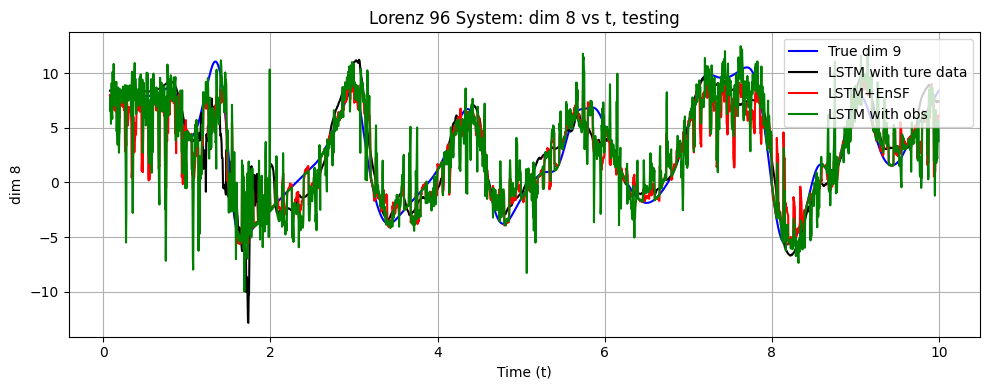

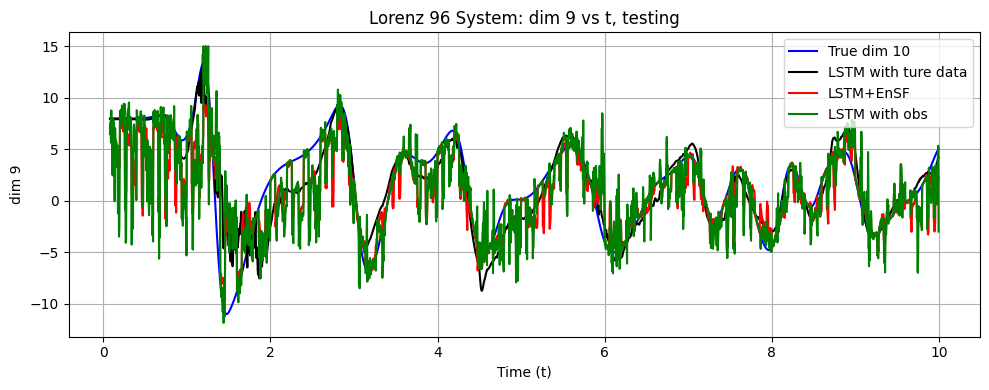

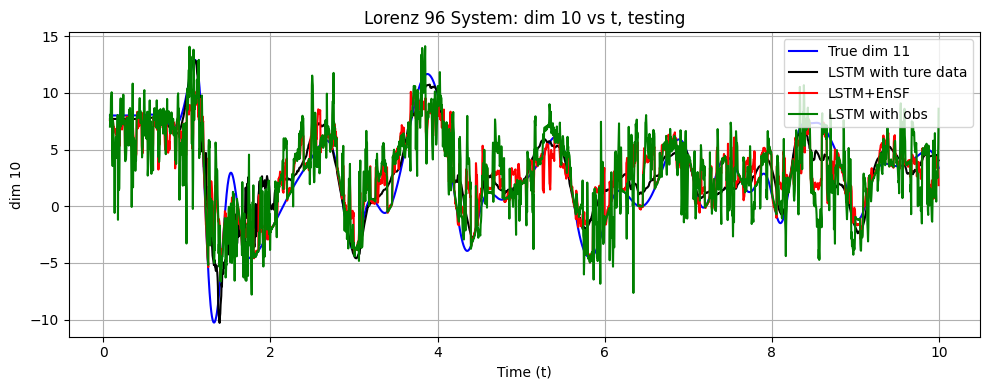

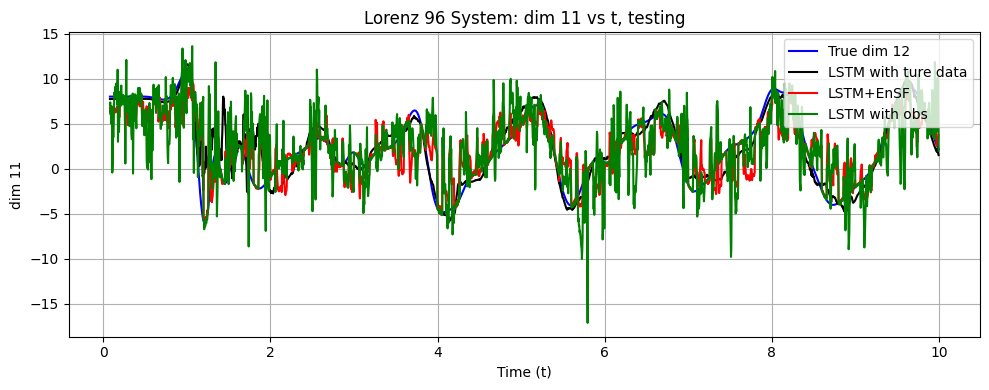

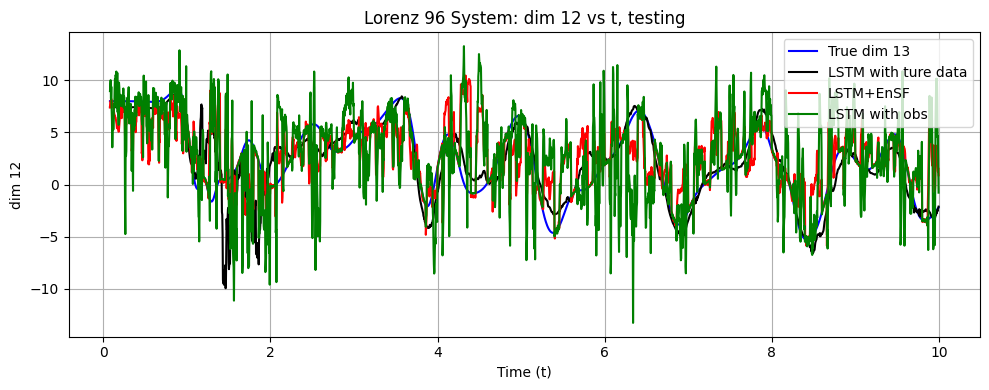

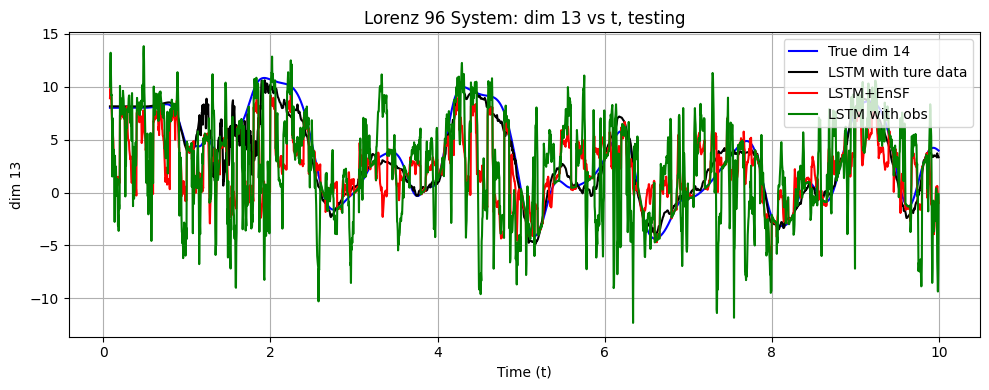

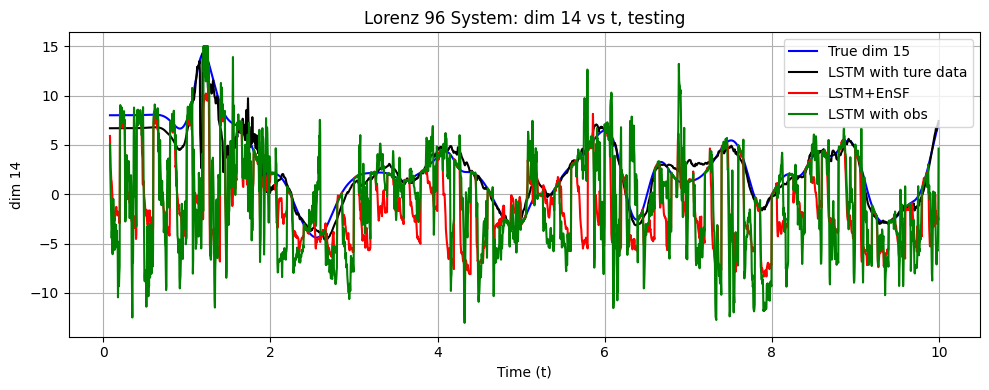

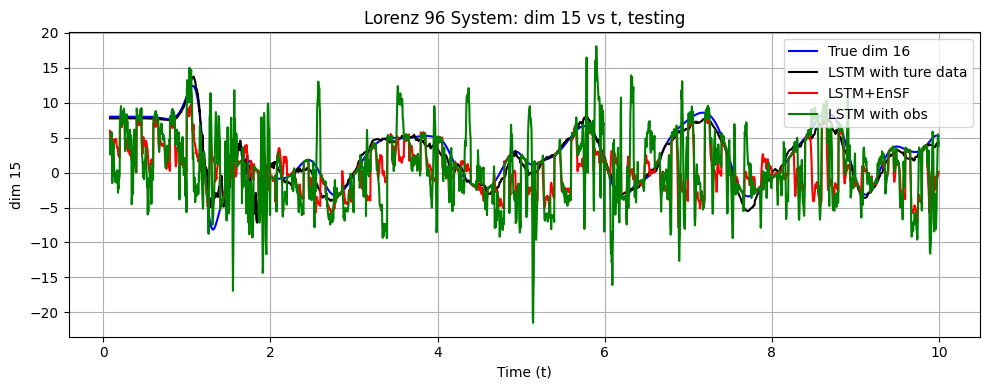

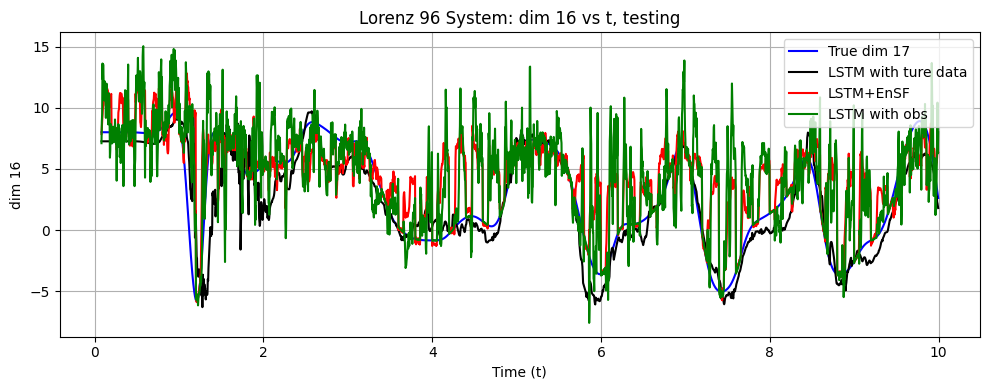

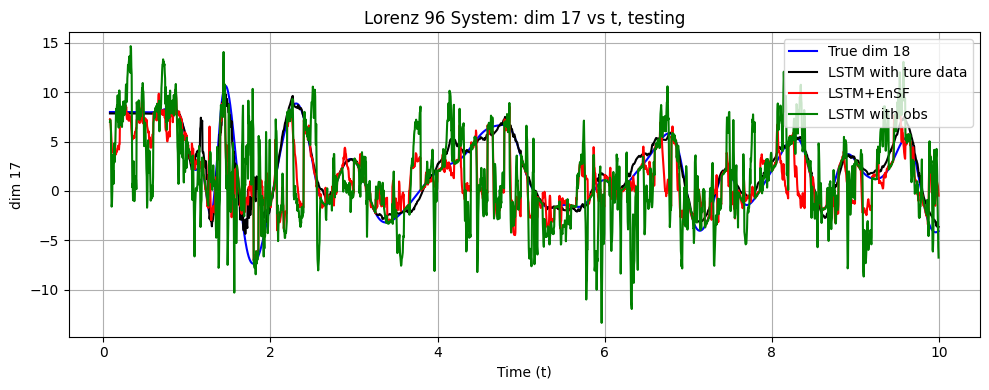

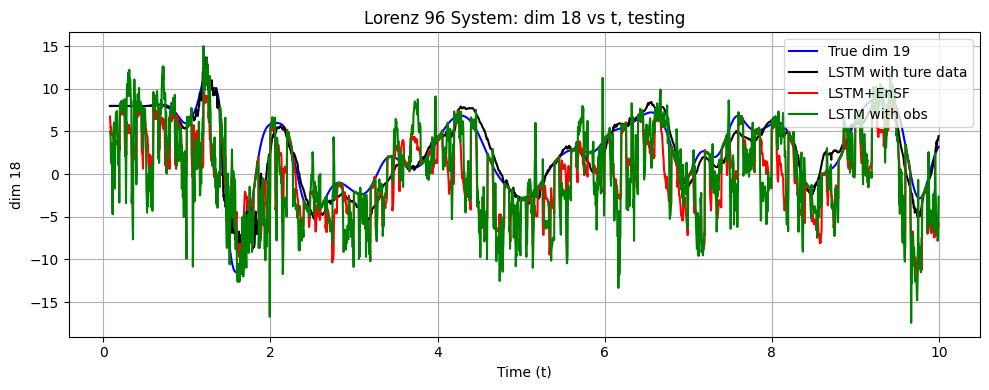

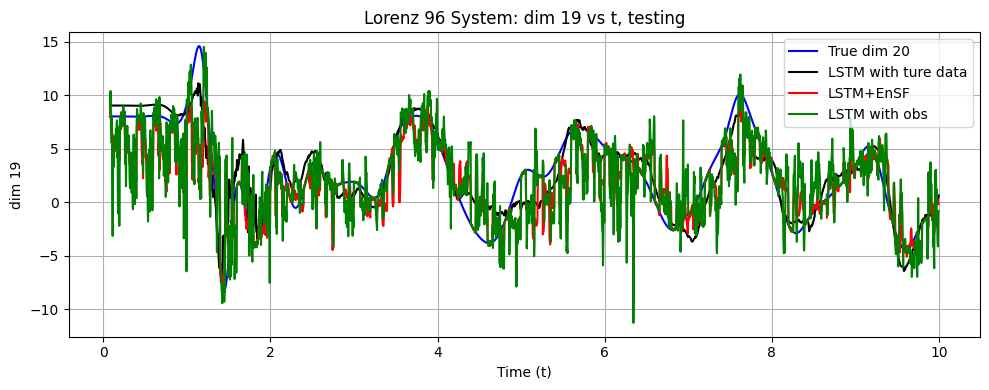

In [41]:
for i in range(dim_x):
    if_plot = 1#np.random.randint(2)
    if if_plot:
        plt.figure(figsize = (10, 4))
        plt.plot(t[LSTM_seq_len: ], sol[LSTM_seq_len: , i], label = 'True dim ' + str(i + 1), color = 'blue')
        #plt.scatter(t[LSTM_seq_len: ], y_fifo[:, i], label = 'pre DA', color = 'red')
        plt.plot(t[LSTM_seq_len: ], fifo_y[:, i], label = 'LSTM with ture data', color = 'black')
        plt.plot(t[LSTM_seq_len: ], rr[:, i], label = 'LSTM+EnSF', color = 'red')
        plt.plot(t[LSTM_seq_len: ], y_fifo_obs[:, i], label = 'LSTM with obs', color = 'green')
        plt.title("Lorenz 96 System: dim " + str(i) + " vs t, testing")
        plt.xlabel("Time (t)")
        plt.ylabel("dim " + str(i))
        plt.grid(True)
        plt.legend(loc = "upper right")
        plt.tight_layout()
        plt.show()

In [42]:
loss_fn(torch.from_numpy(y_fifo_obs), torch.from_numpy(sol[LSTM_seq_len: , :]))

tensor(13.1538, dtype=torch.float64)